# Import Libraries

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics 
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
import catboost as cb
import tensorflow as tf
from keras import callbacks
from keras.layers import Dense, Input, Dropout, Normalization
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.models import load_model
tf.random.set_seed(42)
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import RandomizedSearchCV

# Data Cleaning

## Load the dataset
This dataset is taken from the Kaggle page 'https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package/data'.

This dataset comprises about 10 years of daily weather observations from numerous locations across Australia. The observations were gathered from a multitude of weather stations. You can access daily observations from 'http://www.bom.gov.au/climate/data'.

In [95]:
# Load the dataset into a dataframe
df = pd.read_csv('weatherAUS.csv')

## Information about the data
On this section we will explorate how is the dataset composed and how many columns and rows does it have. After that we will check the quality of the data investigating on the nan values.

### First Look

In [96]:
df.head()

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

### Size

In [97]:
df.shape

(145460, 23)

The dataset is composed by 145460 rows and 23 columns.

## Data Cleaning

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

We transform columns 'RainToday' and 'RainTomorrow' into boolean value.

In [99]:
df['RainTomorrow'] = df['RainTomorrow'].map({'Yes': 1, 'No': 0})
df['RainToday'] = df['RainToday'].map({'Yes': 1, 'No': 0})

### Check for NaN values

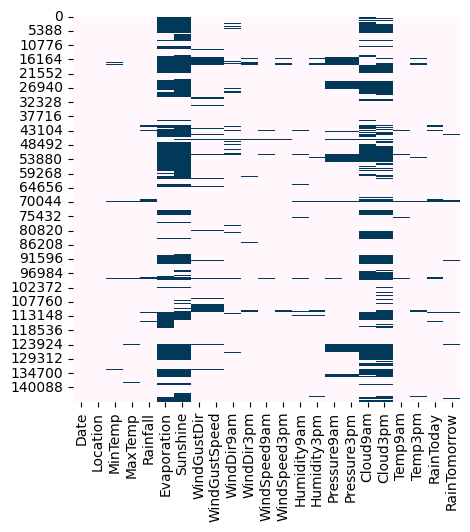

In [100]:
plt.figure(figsize=(5,5))
sns.heatmap(df.isnull(), cbar=False, cmap='PuBu')
plt.show()

In [101]:
# create a table with data missing 
missing_values = df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0           0.000000    object
Location                     0           0.000000    object
MinTemp                   1485           1.020899   float64
MaxTemp                   1261           0.866905   float64
Rainfall                  3261           2.241853   float64
Evaporation              62790          43.166506   float64
Sunshine                 69835          48.009762   float64
WindGustDir              10326           7.098859    object
WindGustSpeed            10263           7.055548   float64
WindDir9am               10566           7.263853    object
WindDir3pm                4228           2.906641    object
WindSpeed9am              1767           1.214767   float64
WindSpeed3pm              3062           2.105046   float64
Humidity9am               2654           1.824557   float64
Humidity3pm               4507           3.098446   float64
Pressure9am              15065          10.356799   float64
Pressure3pm              15028          10.331363   float64
Cloud9am                 55888          38.421559   float64
Cloud3pm                 59358          40.807095   float64
Temp9am                   1767           1.214767   float64
Temp3pm                   3609           2.481094   float64
RainToday                 3261           2.241853   float64
RainTomorrow              3267           2.245978   float64

### FInding all the categorical and continuos features

In [102]:
categorical, contin=[],[]

for i in df.columns:
    
    if df[i].dtype == 'object':
        categorical.append(i)
    else:
        contin.append(i)
        
print(categorical)
print(contin)

['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow']


### Explore Problems within categorical features

Missing values in categorical features

In [103]:
(df[categorical].isnull().sum()/len(df[categorical]))

Date           0.000000
Location       0.000000
WindGustDir    0.070989
WindDir9am     0.072639
WindDir3pm     0.029066
dtype: float64

We can fill missing values in categorical features with the mode

In [104]:
for i in categorical:
    df[i].fillna(df[i].mode()[0], inplace=True)

And we convert them into continuous

In [105]:
lencoders = {}
for col in df.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    df[col] = lencoders[col].fit_transform(df[col])

### Explore Problems with numerical features

In [106]:
(df[contin].isnull().sum()/len(df[contin]))

MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustSpeed    0.070555
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

Since columns 'RainToday' and 'RainTomorrow' contain only binary values, we can fill NaN values with the mode.

In [107]:
df = df.dropna(subset=['RainToday', 'RainTomorrow'])

For the other values we use the **Multiple Imputation by Chained Equations (MICE)**. In particular this process is caracterised by the folllowing steps:
- Firstly all NaN values are initialised with the mean, median or a random variable
- For each variable with missing values, the imputator builds a regression model. This model uses the other variables in the dataset as predictors.
- The cycle continues until all missing values in all variables have been imputed.
- The process can be repeated for several iterations. At each iteration, the imputed values can be refined using the improved information from the previous imputations.
- The algorithm can continue to iterate until a convergence criterion is reached, or up to a maximum number of iterations. 

In [108]:
# Multiple Imputation by Chained Equations
mice_imputer = IterativeImputer()
df.iloc[:,:] = mice_imputer.fit_transform(df)

/Users/filippovicentini/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/impute/_iterative.py:801: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


Final check

In [109]:
# create a table with data missing 
missing_values=df.isnull().sum() # missing values

percent_missing = df.isnull().sum()/df.shape[0]*100 # missing value %

value = {
    'missing_values ':missing_values,
    'percent_missing %':percent_missing , 
     'data type' : df.dtypes
}
frame=pd.DataFrame(value)
frame

missing_values   percent_missing % data type
Date                         0                0.0     int64
Location                     0                0.0     int64
MinTemp                      0                0.0   float64
MaxTemp                      0                0.0   float64
Rainfall                     0                0.0   float64
Evaporation                  0                0.0   float64
Sunshine                     0                0.0   float64
WindGustDir                  0                0.0     int64
WindGustSpeed                0                0.0   float64
WindDir9am                   0                0.0     int64
WindDir3pm                   0                0.0     int64
WindSpeed9am                 0                0.0   float64
WindSpeed3pm                 0                0.0   float64
Humidity9am                  0                0.0   float64
Humidity3pm                  0                0.0   float64
Pressure9am                  0                0.0   float64
Pressure3pm                  0                0.0   float64
Cloud9am                     0                0.0   float64
Cloud3pm                     0                0.0   float64
Temp9am                      0                0.0   float64
Temp3pm                      0                0.0   float64
RainToday                    0                0.0   float64
RainTomorrow                 0                0.0   float64

Now we can see that there aren't NaN values anymore

### Outliers

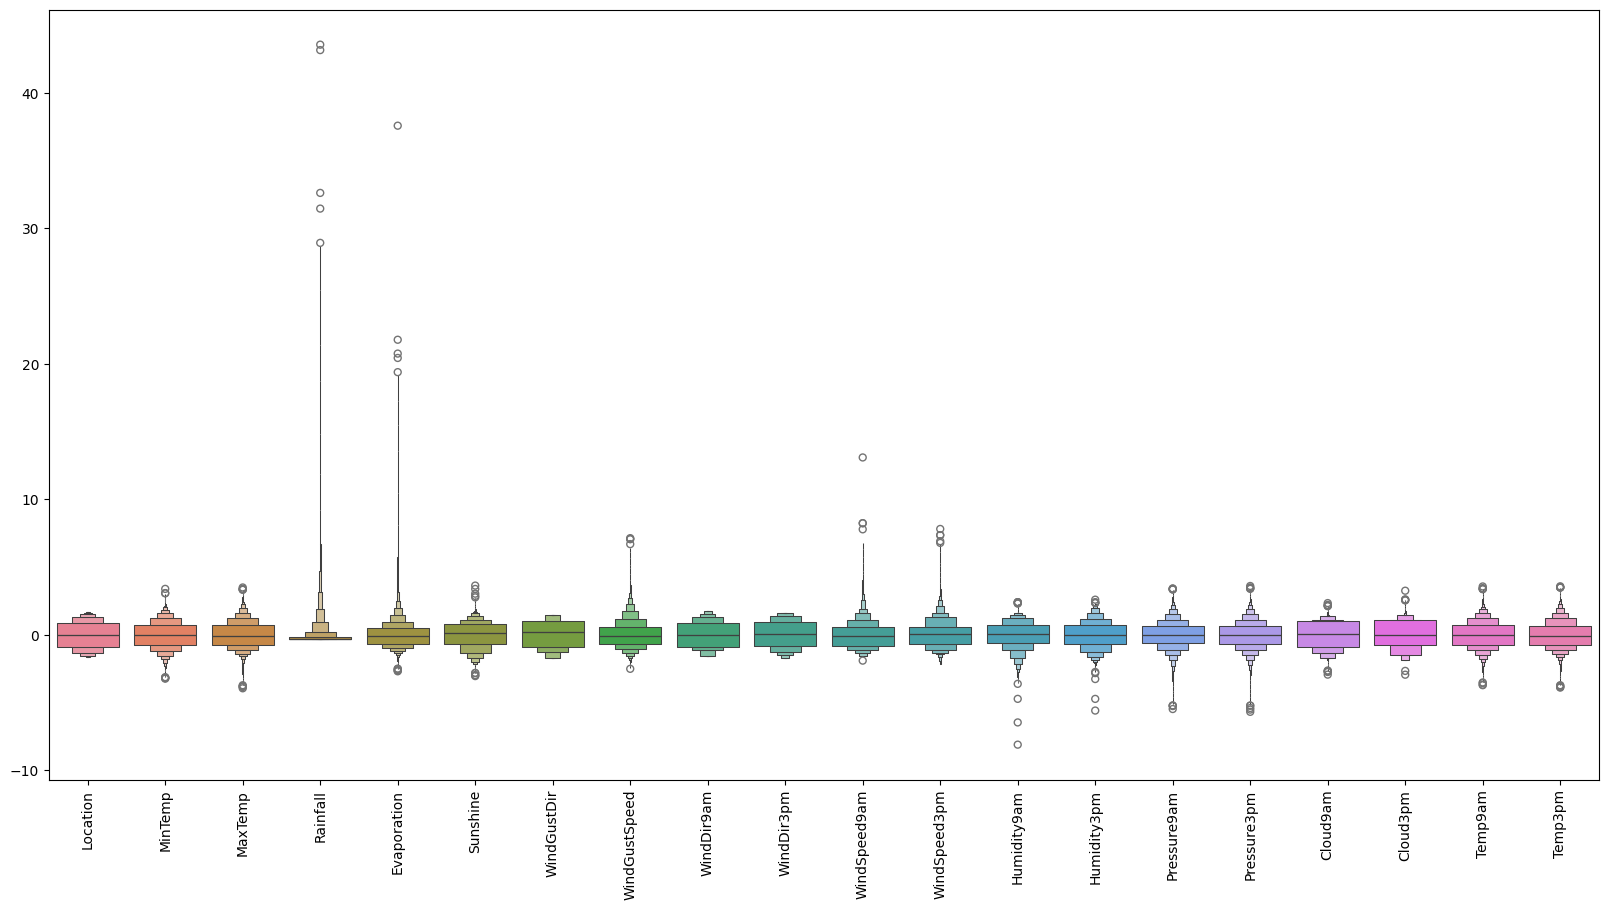

In [110]:
# Prepairing attributes of scale data

features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#Detecting outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

From this first chart we can see that, in particular, columns 'Rainfall', 'Evaporation' and 'WindSpeed9am' are caracterised with an high value of outliers.

Now, in order to fix outliers, we add three functions:
- **outlier_thresholds**: this function calculates, for the specific column of the dataset, its first and third quantile and the Interquantile Range (IQR). It is defined as the range between the first quartile (Q1) and the third quartile (Q3) in a dataset. To find the boundaries for identifying potential outliers based on the IQR, a common rule of thumb is to consider values outside the range: $$[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR]$$
- **check_outliers**: this function verifies that in a specific column there are outliers by checking if there are values outside the previous range. It returns True if there are outliers in that specific column otherwise False
- **replace_with_thresholds**: a common practice is the replace outliers with the specific threshold. In particular, values that are lower than the lower bound are substituted with the lower bound and values that are bigger than the upper bound are replaced with the upper bound.

In [111]:
# Outlier Equation
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Removing the outliers
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

In [112]:
print('Before removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    print(column, check_outlier(df, column))

print('Before delecting outliers the dataset contains', df.shape[0], 'rows')

Before removing the outliers :
MinTemp True
MaxTemp True
Rainfall True
Evaporation True
Sunshine True
WindGustDir False
WindGustSpeed True
WindDir9am False
WindDir3pm False
WindSpeed9am True
WindSpeed3pm True
Humidity9am True
Humidity3pm True
Pressure9am True
Pressure3pm True
Cloud9am False
Cloud3pm False
Temp9am True
Temp3pm True
Before delecting outliers the dataset contains 140787 rows


In [113]:
print('After removing the outliers :')
for column in (df.drop(columns = ['RainTomorrow', 'RainToday', 'Date', 'Location']).columns):
    replace_with_thresholds(df, column)
    print(column, check_outlier(df, column))

print('After delecting outliers the dataset contains', df.shape[0], 'rows')

After removing the outliers :
MinTemp False
MaxTemp False
Rainfall False
Evaporation False
Sunshine False
WindGustDir False
WindGustSpeed False
WindDir9am False
WindDir3pm False
WindSpeed9am False
WindSpeed3pm False
Humidity9am False
Humidity3pm False
Pressure9am False
Pressure3pm False
Cloud9am False
Cloud3pm False
Temp9am False
Temp3pm False
After delecting outliers the dataset contains 140787 rows


Final check

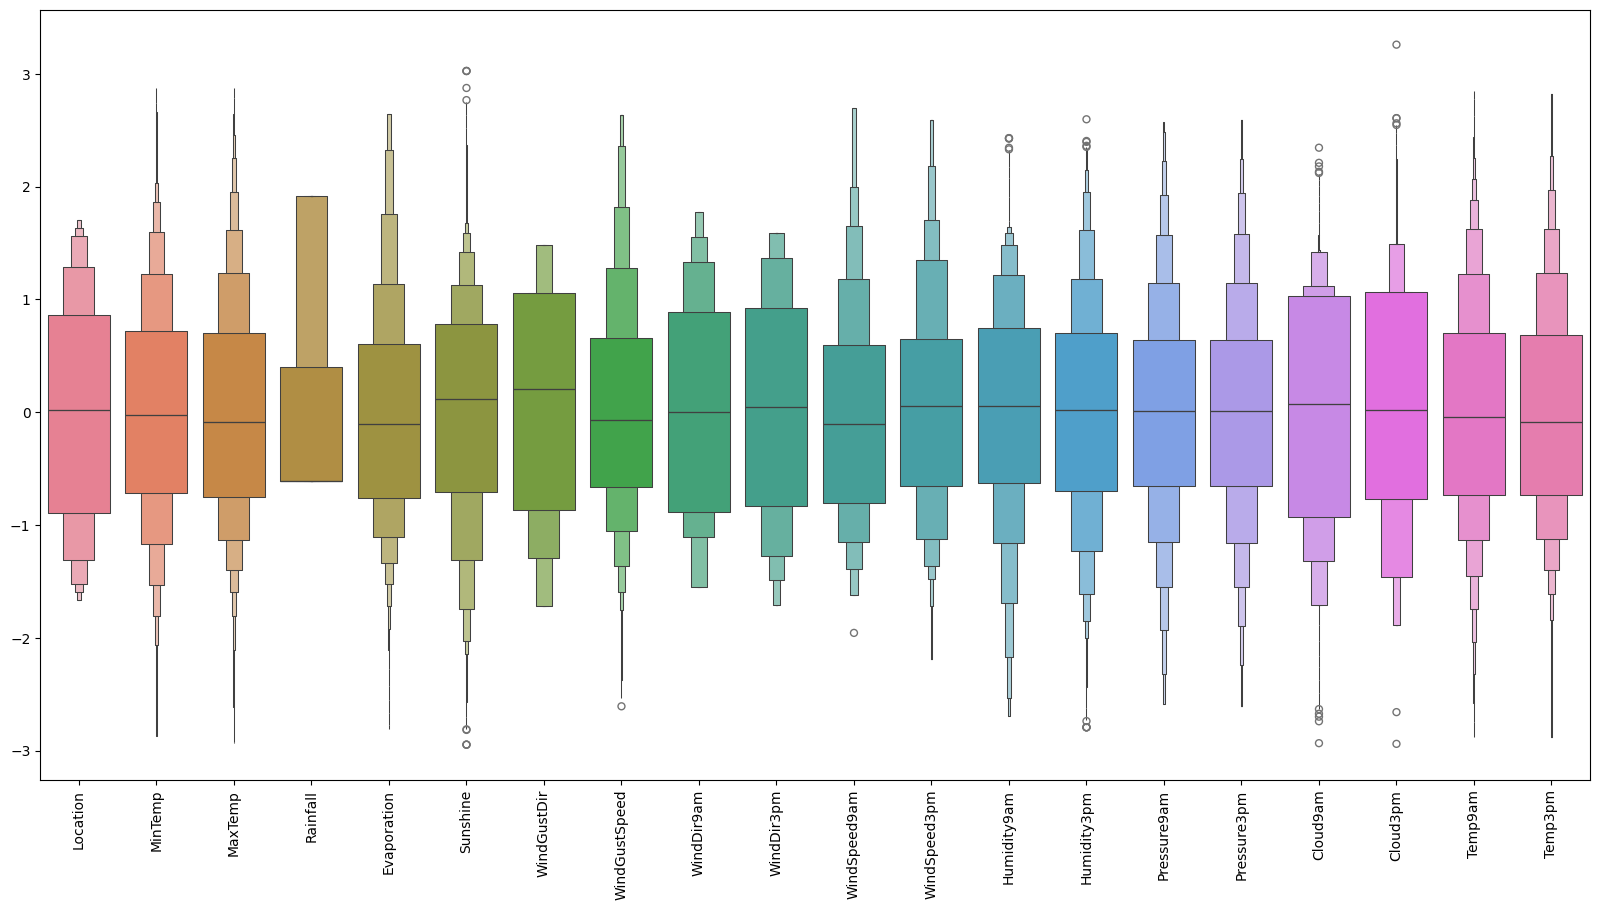

In [114]:
features = df.drop(['RainTomorrow','RainToday','Date'], axis=1) # dropping target and extra columns

# Set up a standard scaler for the features
col_names = list(features.columns)
s_scaler = StandardScaler()
features = s_scaler.fit_transform(features)
features = pd.DataFrame(features, columns=col_names) 

#Detecting outliers

plt.figure(figsize=(20,10))
sns.boxenplot(data = features)
plt.xticks(rotation=90)
plt.show()

### Multicollinearity Problem

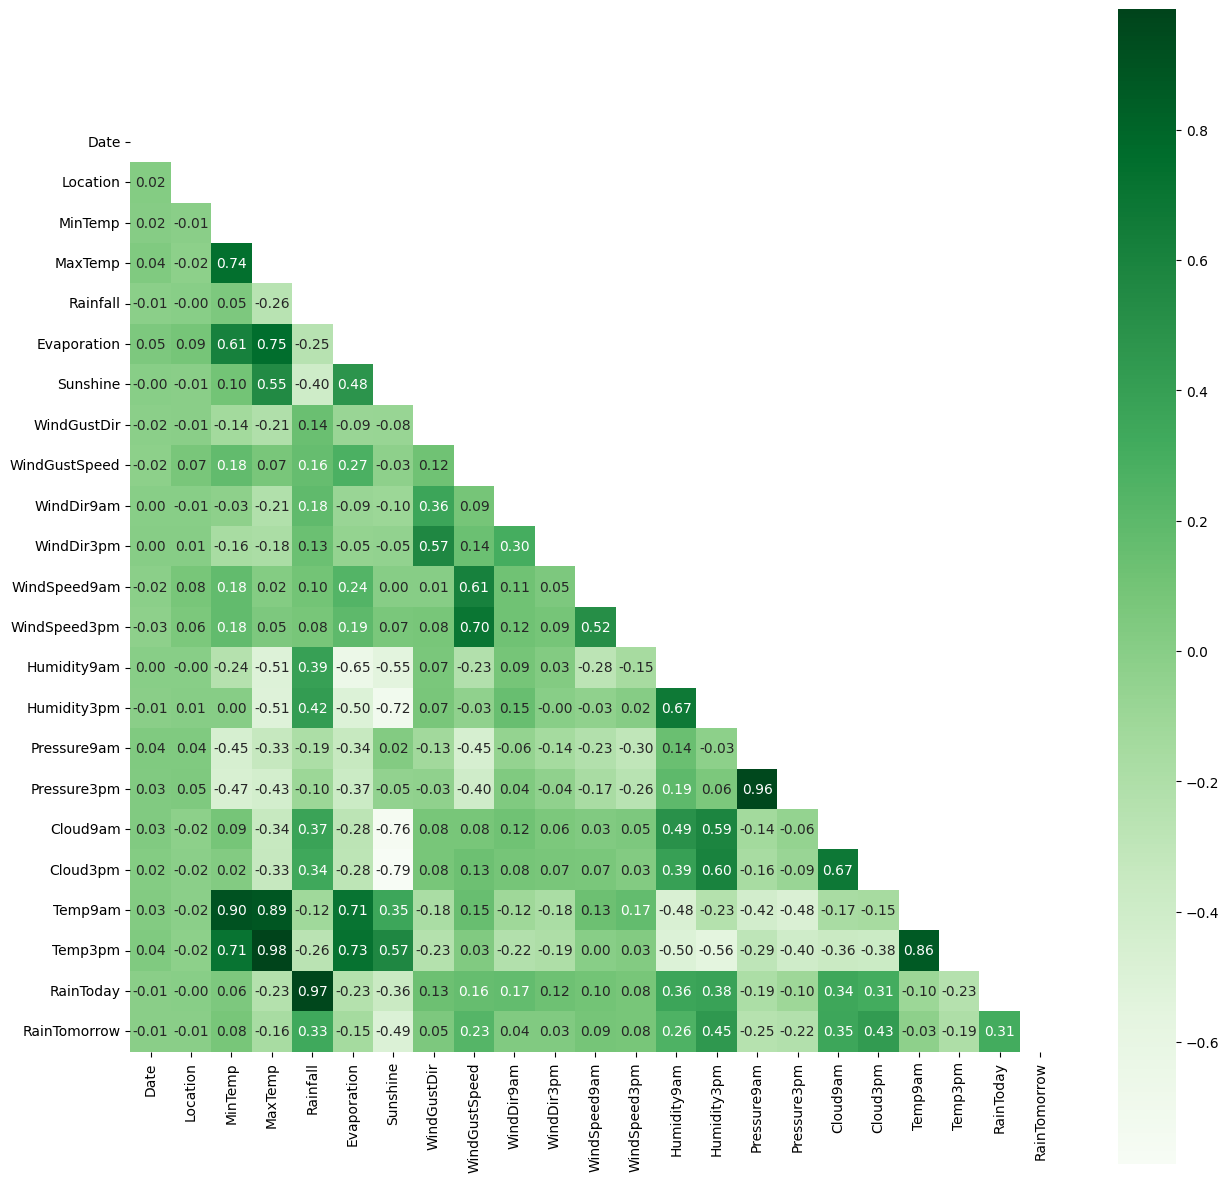

In [115]:
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(15,15))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, fmt='.2f', cmap='Greens')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

From the matrix we can observe that some features are higly correlated. So, we can adopt the **VIF** method or Variance Inflaction Factor. In VIF method, we pick each feature and regress it against all of the other features. For each regression, the factor is calculated as :
$$ VIF = \frac{1}{1 - R^2}$$
As we see from the formula, greater the value of $R^2$, greater is the $VIF$. Hence, greater VIF denotes greater correlation.


In [116]:
# Aggiungere una costante per rappresentare l'intercetta
X = add_constant(df.drop(['RainTomorrow'], axis=1))

# Calcolare il VIF per ogni variabile
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


          feature           VIF
0           const  42895.368606
1            Date      1.018929
2        Location      1.047981
3         MinTemp     10.913257
4         MaxTemp     49.489312
5        Rainfall     16.580306
6     Evaporation      3.825695
7        Sunshine      5.561406
8     WindGustDir      1.625751
9   WindGustSpeed      3.052519
10     WindDir9am      1.296368
11     WindDir3pm      1.649698
12   WindSpeed9am      1.946736
13   WindSpeed3pm      2.283782
14    Humidity9am      4.634038
15    Humidity3pm      6.831119
16    Pressure9am     24.156399
17    Pressure3pm     23.047133
18       Cloud9am      2.939746
19       Cloud3pm      3.097270
20        Temp9am     23.130815
21        Temp3pm     55.813142
22      RainToday     15.481262


Now, step by step, we select the variable with the highest VIP value and we remove it. In this way, we saw that deleting 'Temp3pm', 'Temp9am', 'Pressure9am' and 'Rainfall' features produced an important decrease.

In [117]:
# Rimuovere variabili con VIF alto
df_reduced = df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1)

# Calcolare di nuovo il VIF per le variabili rimanenti
X_reduced = add_constant(df_reduced.drop(['RainTomorrow'], axis=1))
vif_data_reduced = pd.DataFrame()
vif_data_reduced["feature"] = X_reduced.columns
vif_data_reduced["VIF"] = [variance_inflation_factor(X_reduced.values, i) for i in range(X_reduced.shape[1])]

print(vif_data_reduced)


          feature           VIF
0           const  40997.355023
1            Date      1.017124
2        Location      1.047595
3         MinTemp      5.632420
4         MaxTemp      8.076934
5     Evaporation      3.622047
6        Sunshine      5.386117
7     WindGustDir      1.608791
8   WindGustSpeed      2.963506
9      WindDir9am      1.275748
10     WindDir3pm      1.559324
11   WindSpeed9am      1.923351
12   WindSpeed3pm      2.205405
13    Humidity9am      2.857789
14    Humidity3pm      4.017509
15    Pressure3pm      1.671573
16       Cloud9am      2.896079
17       Cloud3pm      3.006611
18      RainToday      1.362173


So we can drop them

In [118]:
df.drop(['Temp3pm', 'Pressure9am', 'Temp9am', 'Rainfall'], axis=1, inplace=True)

# Machine Learning
Now we can focus our attention on predicting the target column 'RainTomorrow' by using different ML algorithm.

In [119]:
df.drop('Date',axis = 1, inplace = True)

## Data Preprocessing

From the chart we can see that we have the problem of **IMBALACED DATASET**.

This aspect is a problem in the field of Machine Learning because when we try to apply any prediction algorithm we will notice that it will predict the majority class well, but not the minority.

This is because the algorithm was trained on an instance that had a majority of 'NO' cases.

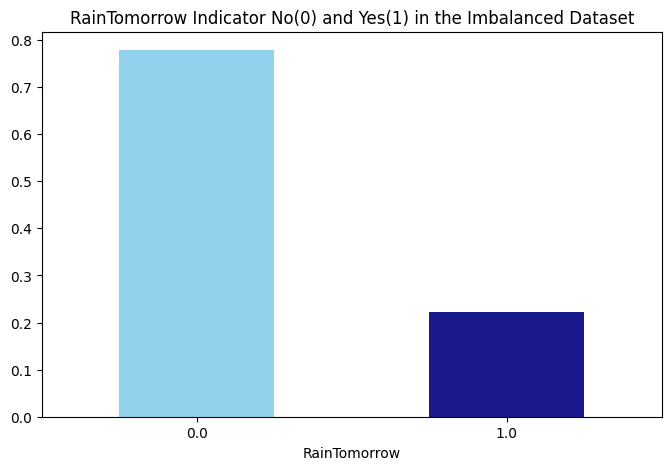

In [120]:
fig = plt.figure(figsize = (8,5))
df.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

But **BEFORE** trying to use some skills to avoid this problem we have to split the data into train and test set:

### Divide the data into train and test set

In [121]:
X = df.drop('RainTomorrow', axis = 1)
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=df['RainTomorrow'])

print('X_train size', X_train.shape)
print('y_train size', y_train.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

X_train size (105590, 17)
y_train size (105590,)
X_test size (35197, 17)
y_test size (35197,)


### Rebalance the data
Now we can try to apply some skills to avoid imbalanced dataset. We are going to use **SMOTE** and **UNDERSAMPLE** on the train set, not to the test set.

#### Synthetic Minority Oversampling Technique (SMOTE)
An improvement on duplicating examples from the minority class is to synthesize new examples from the minority class. Specifically, a random example from the minority class is first chosen. Then k of the nearest neighbors for that example are found (typically k=5). A randomly selected neighbor is chosen and a synthetic example is created at a randomly selected point between the two examples in feature space

In [122]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class Distribution after SMOTE:", y_train_smote.value_counts())

print('X_train size', X_train_smote.shape)
print('y_train size', y_train_smote.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after SMOTE: RainTomorrow
0.0    82189
1.0    82189
Name: count, dtype: int64
X_train size (164378, 17)
y_train size (164378,)
X_test size (35197, 17)
y_test size (35197,)


#### Undersample

In [123]:
rus = RandomUnderSampler(random_state=42, sampling_strategy = 'majority')

X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("Class Distribution after undersample:", y_train_under.value_counts())

print('X_train size', X_train_under.shape)
print('y_train size', y_train_under.shape)
print('X_test size', X_test.shape)
print('y_test size', y_test.shape)

Class Distribution after undersample: RainTomorrow
0.0    23401
1.0    23401
Name: count, dtype: int64
X_train size (46802, 17)
y_train size (46802,)
X_test size (35197, 17)
y_test size (35197,)


### Standardize them

In [124]:
# Standardize the original training set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Standardize the SMOTE training set
scaler_smote = StandardScaler()
X_train_smote_scaled = scaler_smote.fit_transform(X_train_smote)
X_test_smote_scaled = scaler_smote.transform(X_test)

# Standardize the under-sampled training set
scaler_under = StandardScaler()
X_train_under_scaled = scaler_under.fit_transform(X_train_under)
X_test_under_scaled = scaler_under.transform(X_test)

### Model Evaluation Class

In [125]:
class Model:
    def __init__(self, model, name = None, scaled = True, resample = None):
        self.model = model
        self.name = name
        self.scaled = scaled
        self.resample = resample
    def fit(self):
        if self.scaled == True and self.resample == None:
            self.model.fit(X_train_scaled, y_train)
        if self.scaled == False and self.resample == None:
            self.model.fit(X_train, y_train)
        if self.scaled == True and self.resample == 'smote':
            self.model.fit(X_train_smote_scaled, y_train_smote)
        if self.scaled == False and self.resample == 'smote':
            self.model.fit(X_train_smote, y_train_smote)
        if self.scaled == True and self.resample == 'under':
            self.model.fit(X_train_under_scaled, y_train_under)
        if self.scaled == False and self.resample == 'under':
            self.model.fit(X_train_under, y_train_under)
    def __get_predictions(self):
        if self.scaled == True and self.resample == None:
            return self.model.predict(X_test_scaled), self.model.predict_proba(X_test_scaled)[:,1]
        if self.scaled == False and self.resample == None:
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'smote':
            return self.model.predict(X_test_smote_scaled), self.model.predict_proba(X_test_smote_scaled)[:,1]
        if self.scaled == False and self.resample == 'smote':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
        if self.scaled == True and self.resample == 'under':
            return self.model.predict(X_test_under_scaled), self.model.predict_proba(X_test_under_scaled)[:,1]
        if self.scaled == False and self.resample == 'under':
            return self.model.predict(X_test), self.model.predict_proba(X_test)[:,1]
    def get_metrics(self) -> pd.Series:
        y_pred, y_probs = self.__get_predictions()
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        f1 = metrics.f1_score(y_test, y_pred)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        pr_auc = metrics.average_precision_score(y_test, y_probs)
        metrics_series = pd.Series({
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC AUC': roc_auc,
            'Confusion Matrix': conf_mat,
            'PR AUC': pr_auc,
            'Name': self.name
        })
        if self.name == '' or self.name is None:
            metrics_series.Name =type(self.model).__name__
        return metrics_series
    
    def visualize_metrics(self):
        y_pred, y_probs = self.__get_predictions()
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_probs)
        roc_auc = metrics.roc_auc_score(y_test, y_probs)
        # Calculate Precision-Recall curve and AUC
        precision, recall, _ = metrics.precision_recall_curve(y_test, y_probs)
        pr_auc = metrics.auc(recall, precision)
        # Plot ROC curve
        plt.figure(figsize=(20, 10))
        plt.subplot(2, 2, 1)
        plt.axis('equal')
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')

        # Plot Precision-Recall curve
        plt.subplot(2, 2, 2)
        plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AUC = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')

        residuals = y_test - y_probs
        # Plot Confusion Matrix and Distribution of errors
        plt.subplot(2, 2, 3)
        conf_mat = metrics.confusion_matrix(y_test, y_pred)
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.subplot(2, 2, 4)
        sns.histplot(residuals, bins=30, edgecolor='black', kde=True)
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.title('Distribution of Errors')
        plt.show()

In [230]:
models_df = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_smote = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

models_df_under = pd.DataFrame(columns=['Name',
    'Accuracy',
    'Precision',
    'Recall',
    'F1-Score',
    'ROC AUC',
    'Confusion Matrix',
    'PR AUC'])

## Linear Discriminant Analysis (LDA)

### No resample

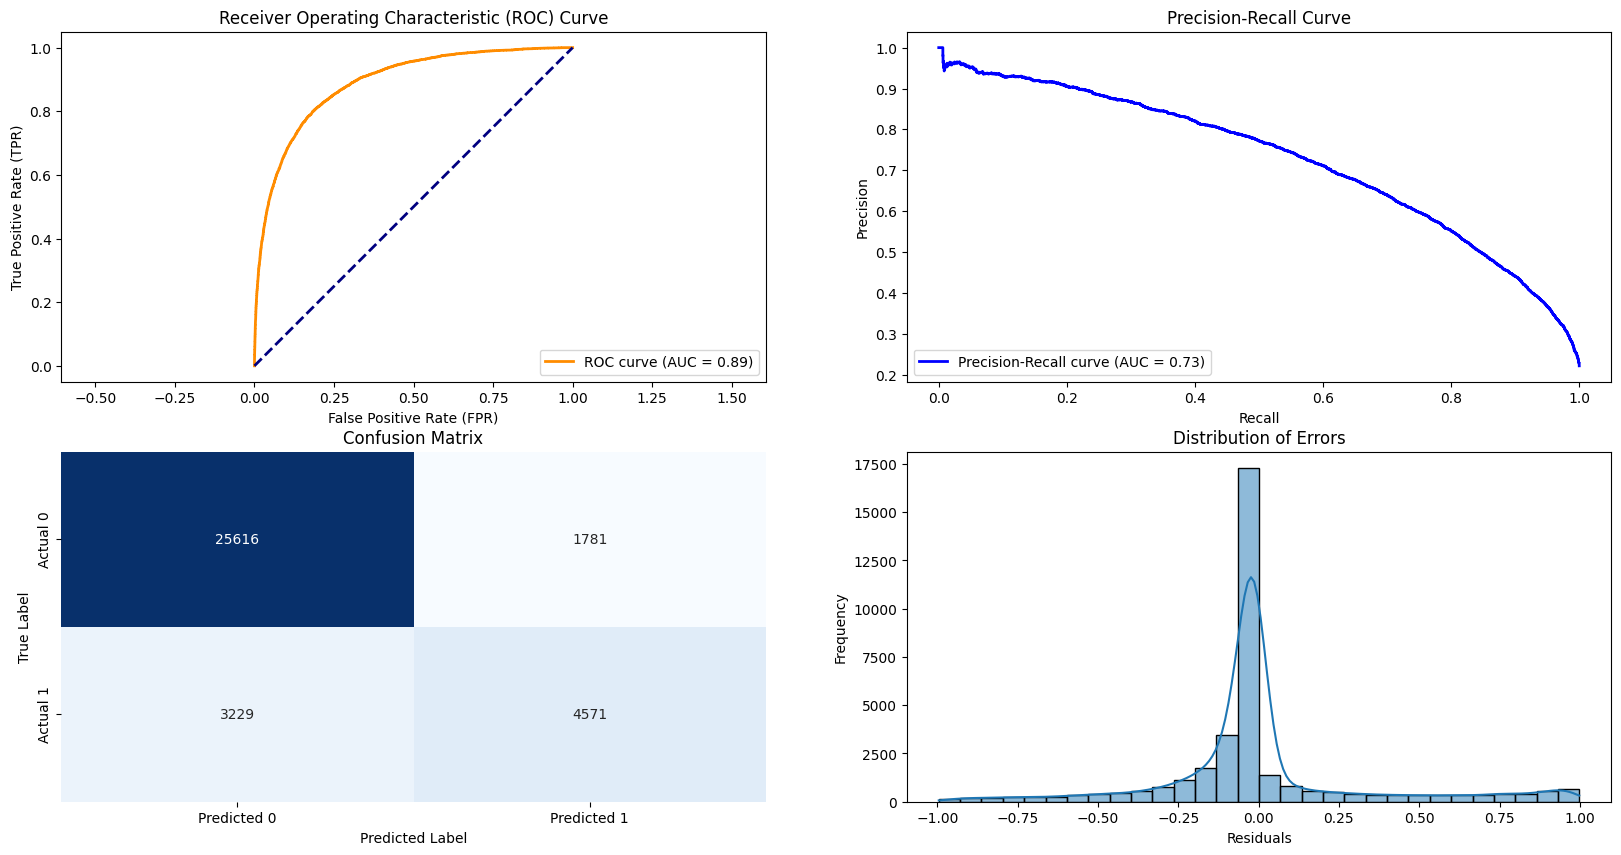

In [231]:
model = Model(LinearDiscriminantAnalysis(), name='LDA No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [232]:
metrics_LDA_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LDA_no_resample.to_frame().T])
print(metrics_LDA_no_resample)

Accuracy                                 0.857658
Precision                                0.719616
Recall                                   0.586026
F1-Score                                 0.645986
ROC AUC                                  0.888372
Confusion Matrix    [[25616, 1781], [3229, 4571]]
PR AUC                                   0.726621
Name                              LDA No Resample
dtype: object


### SMOTE

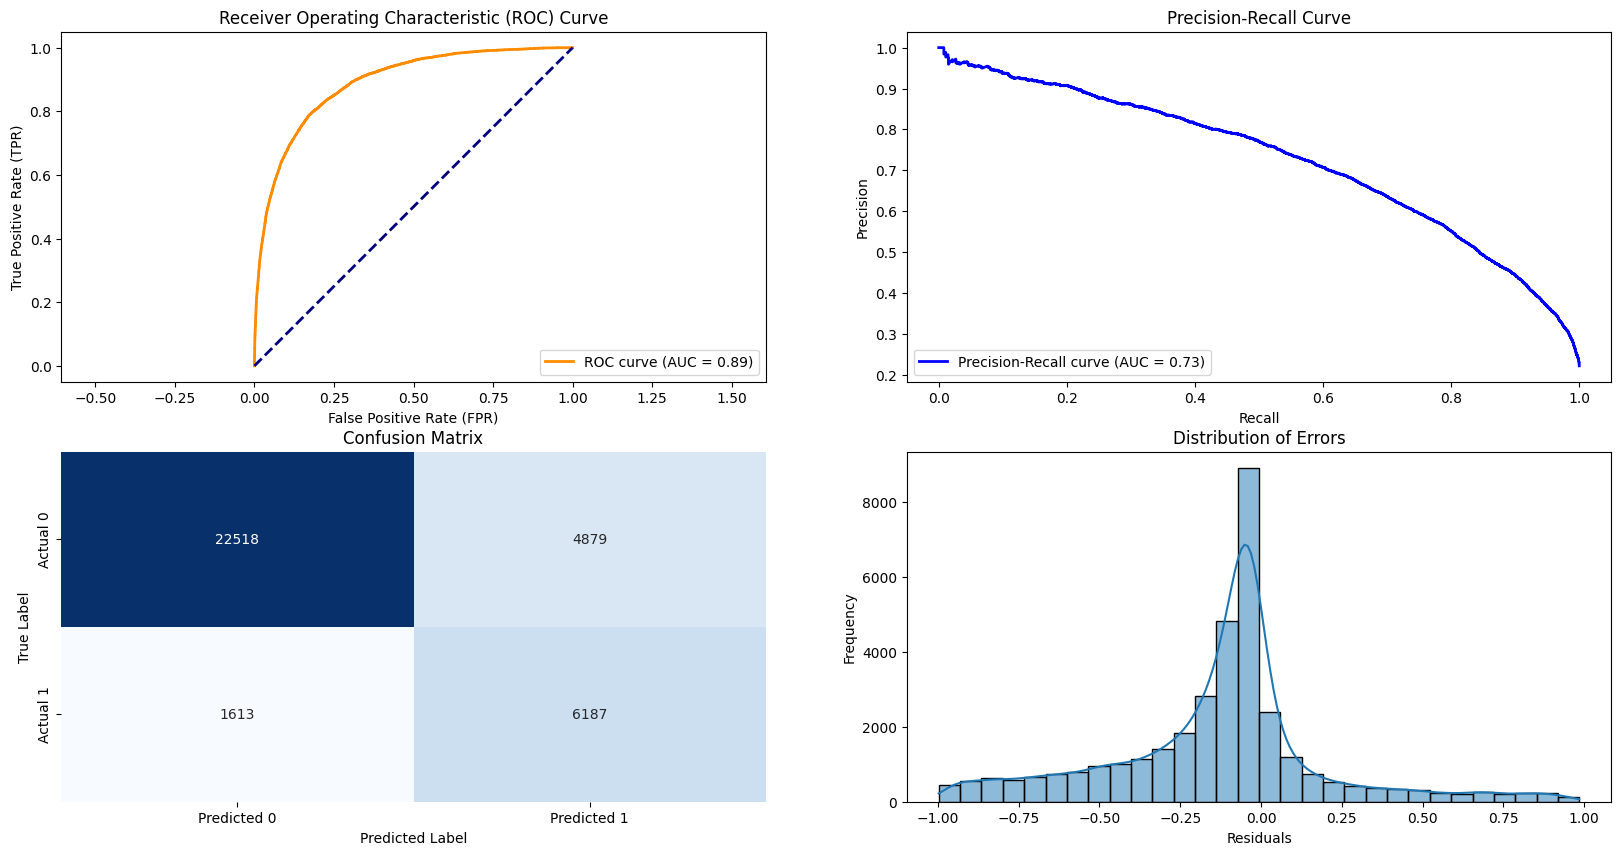

In [233]:
model = Model(LinearDiscriminantAnalysis(), name='LDA SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [234]:
metrics_LDA_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LDA_smote.to_frame().T])
print(metrics_LDA_smote)

Accuracy                                 0.815552
Precision                                  0.5591
Recall                                   0.793205
F1-Score                                 0.655889
ROC AUC                                   0.88866
Confusion Matrix    [[22518, 4879], [1613, 6187]]
PR AUC                                   0.725605
Name                                    LDA SMOTE
dtype: object


### Undersample

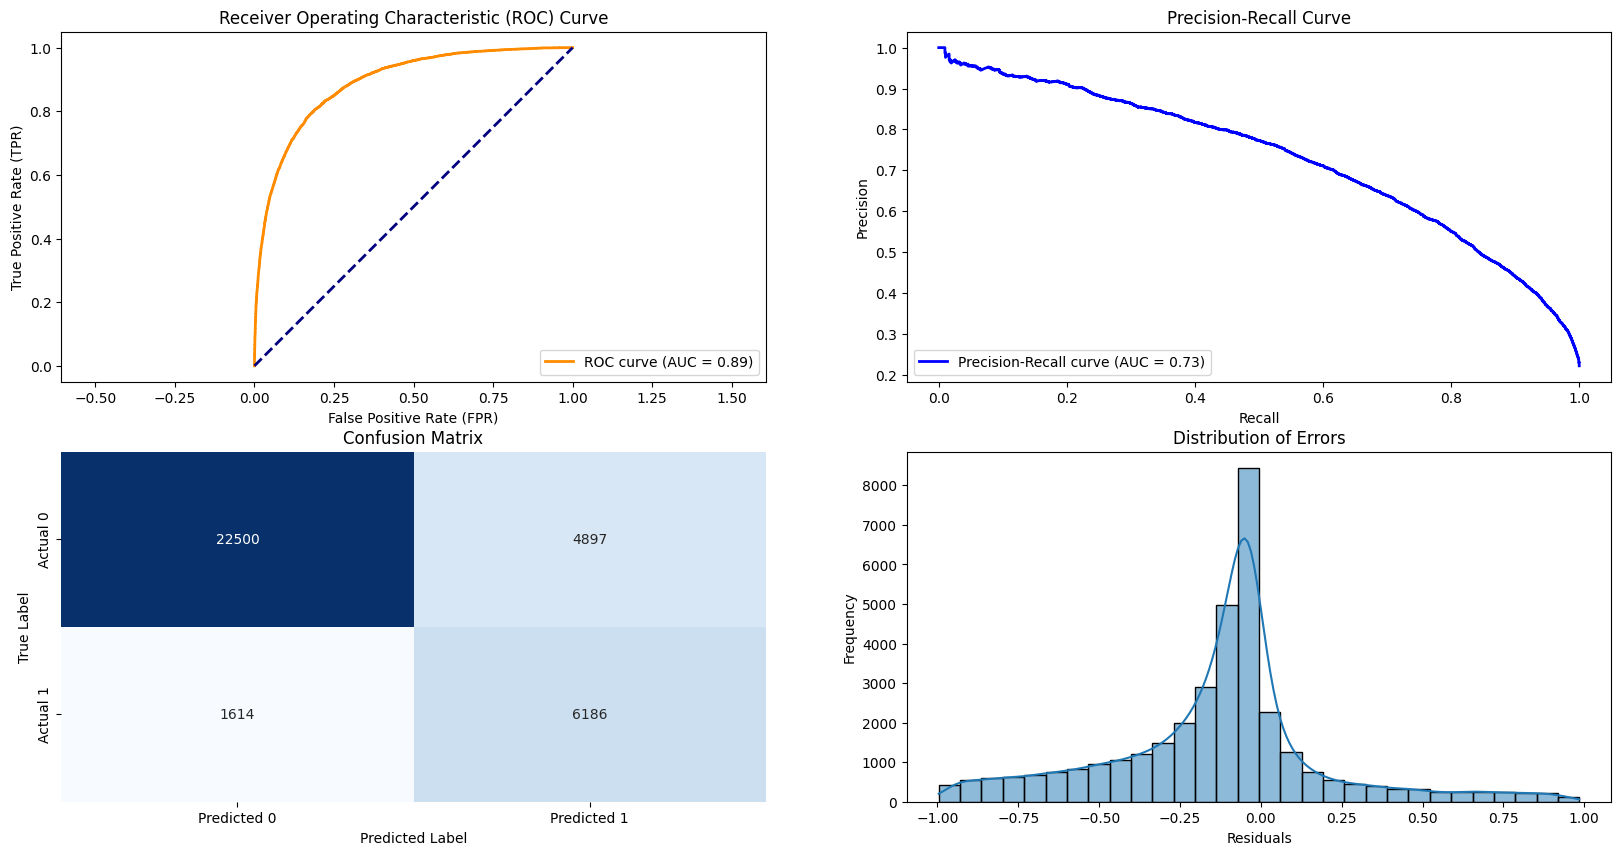

In [235]:
model = Model(LinearDiscriminantAnalysis(), name='LDA undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [236]:
metrics_LDA_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LDA_under.to_frame().T])
print(metrics_LDA_under)

Accuracy                                 0.815013
Precision                                0.558152
Recall                                   0.793077
F1-Score                                 0.655193
ROC AUC                                  0.889145
Confusion Matrix    [[22500, 4897], [1614, 6186]]
PR AUC                                   0.727491
Name                              LDA undersample
dtype: object


## Logistic Regression

### No resample

In [237]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_scaled, y_train)
print(clf.best_params_)

{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


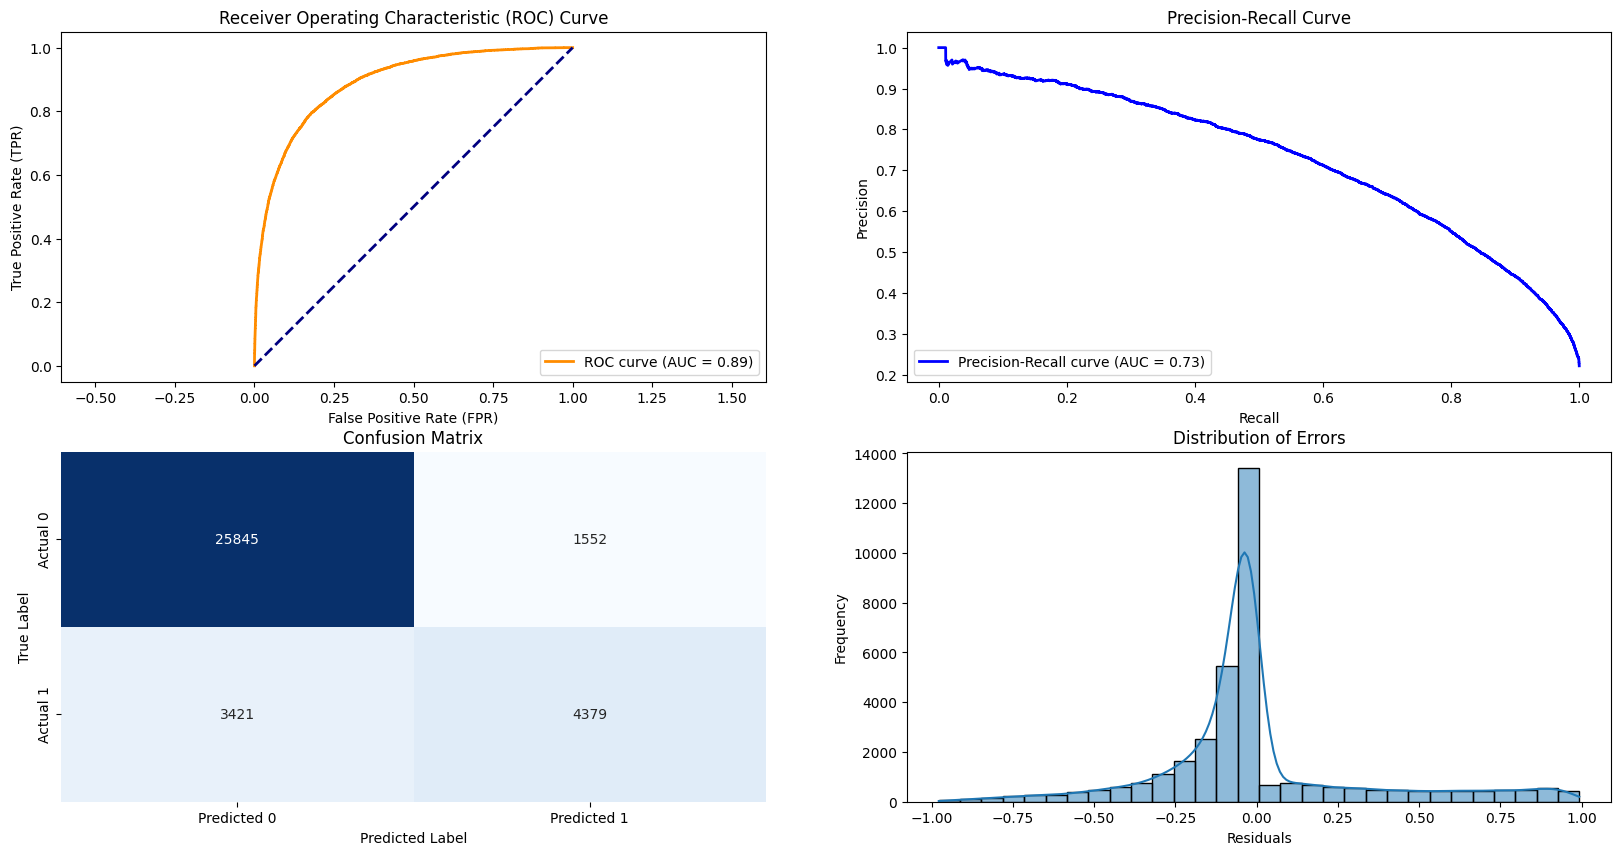

In [238]:
# Create the model
model = Model(LogisticRegression(C = 0.01, penalty = 'l2', solver = 'lbfgs'), 
              name='Logistic Regression No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [239]:
metrics_LR_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_LR_no_resample.to_frame().T])
print(metrics_LR_no_resample)

Accuracy                                    0.85871
Precision                                  0.738324
Recall                                      0.56141
F1-Score                                   0.637827
ROC AUC                                    0.889523
Confusion Matrix      [[25845, 1552], [3421, 4379]]
PR AUC                                     0.729491
Name                Logistic Regression No Resample
dtype: object


### SMOTE

In [240]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_smote_scaled, y_train_smote)
print(clf.best_params_)

{'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


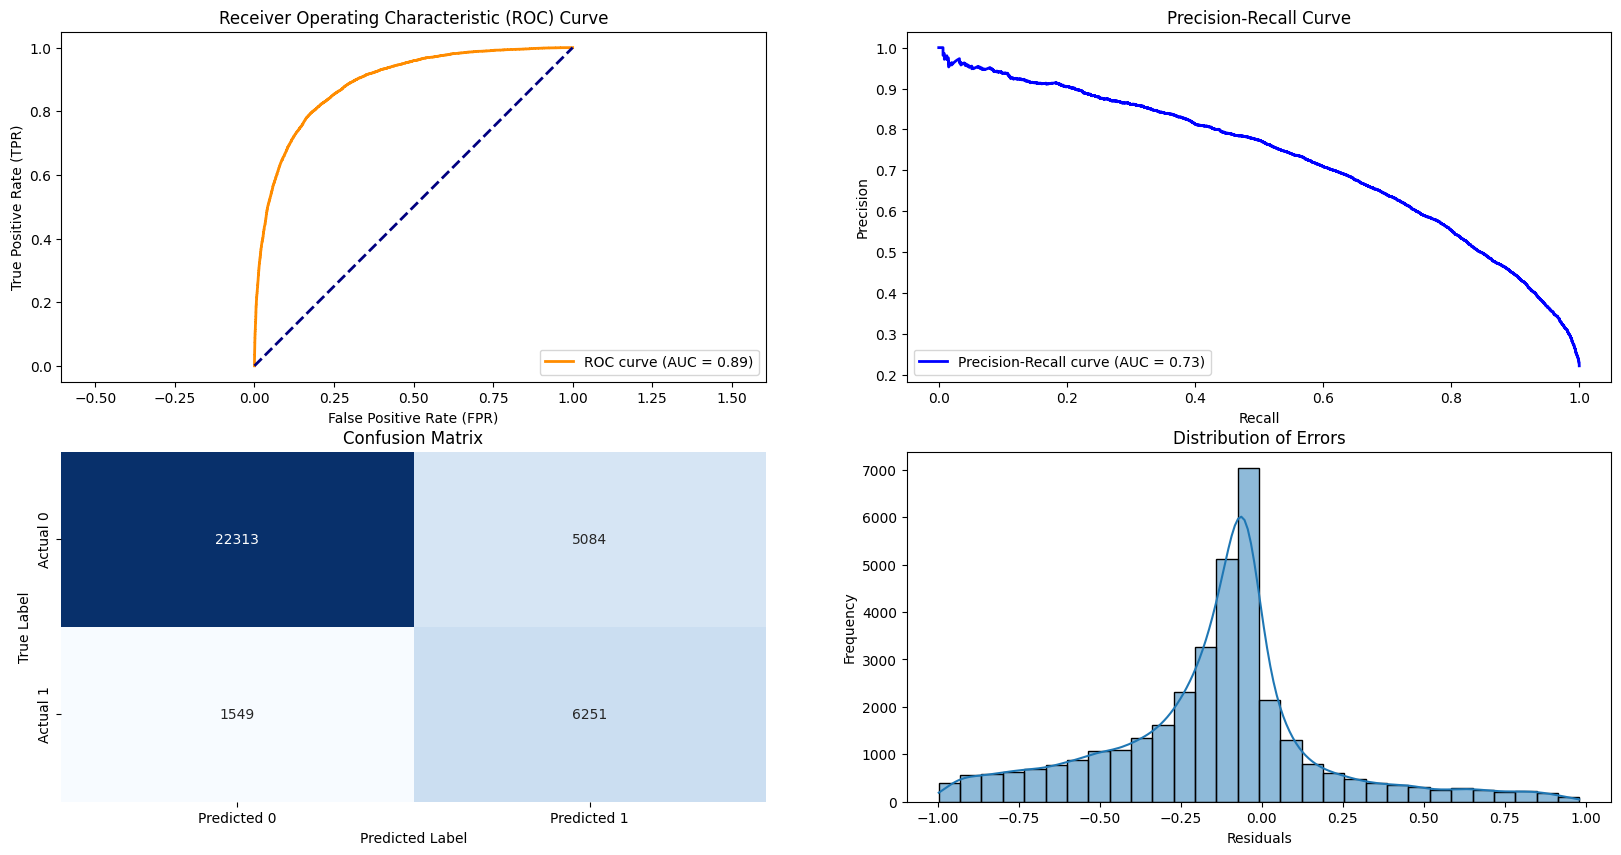

In [241]:
model = Model(LogisticRegression(C = 10, penalty = 'l2', solver = 'lbfgs'), 
              name='Logistic Regression Smote', 
              scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [242]:
metrics_LR_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_LR_smote.to_frame().T])
print(metrics_LR_smote)

Accuracy                                 0.811546
Precision                                0.551478
Recall                                    0.80141
F1-Score                                 0.653358
ROC AUC                                  0.889268
Confusion Matrix    [[22313, 5084], [1549, 6251]]
PR AUC                                   0.726433
Name                    Logistic Regression Smote
dtype: object


### Undersample

In [243]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2'],  # Regularization penalty
    'solver': ['liblinear', 'lbfgs','newton-cg','newton-cholesky','sag','saga']  # Optimization algorithm
}
clf = GridSearchCV(LogisticRegression(), param_grid)
clf = clf.fit(X_train_under_scaled, y_train_under)
print(clf.best_params_)

{'C': 100, 'penalty': 'l2', 'solver': 'sag'}


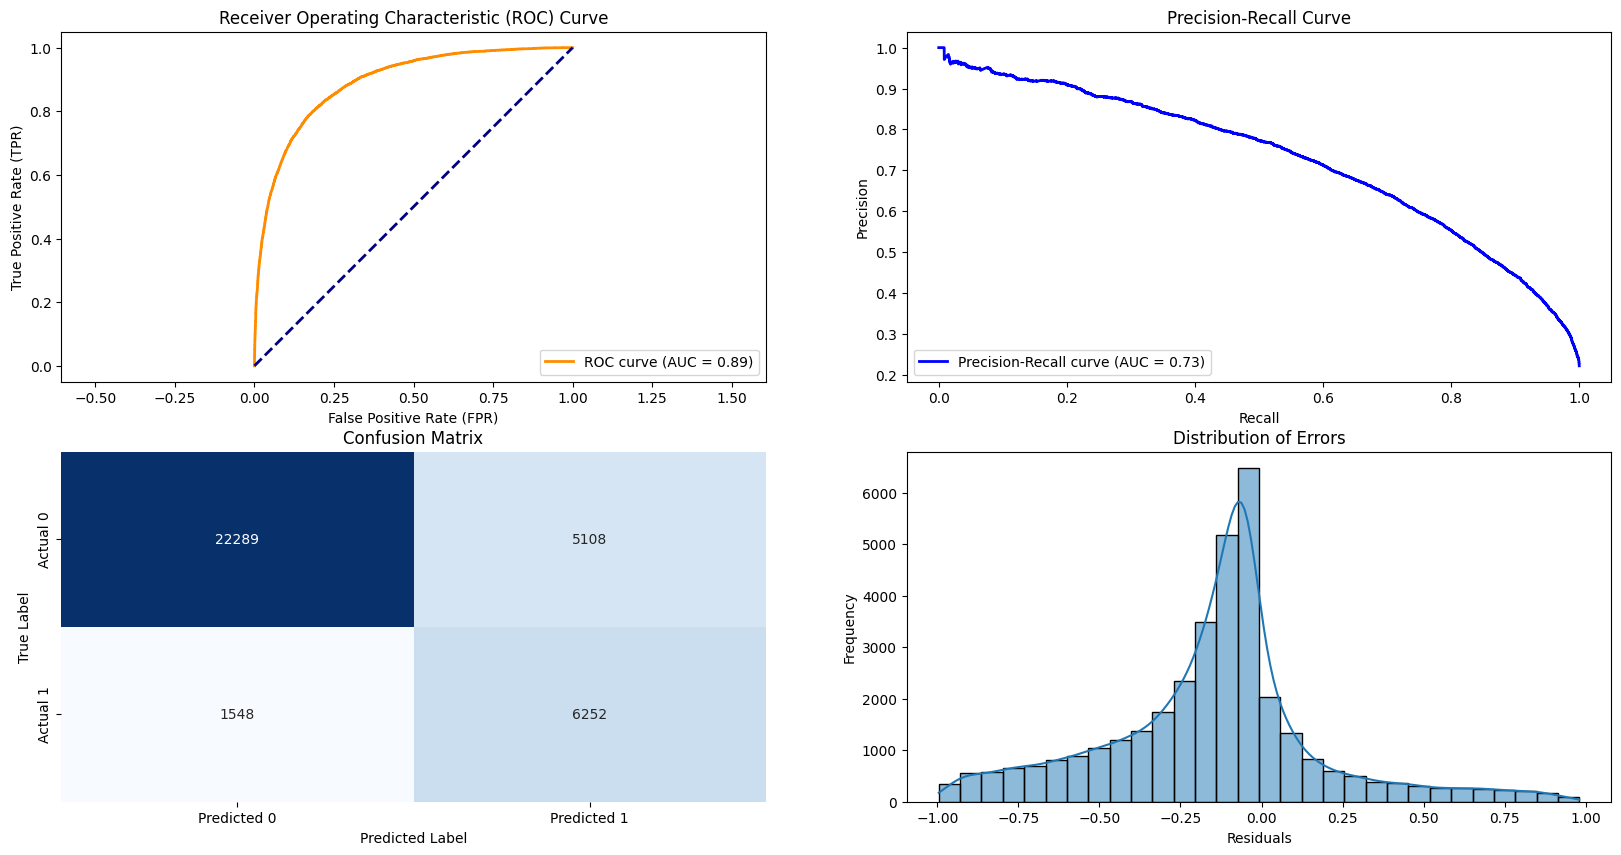

In [244]:
model = Model(LogisticRegression(C = 100, penalty = 'l2', solver = 'sag'), 
              name='Logistic Regression Undersample', 
              scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [245]:
metrics_LR_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_LR_under.to_frame().T])
print(metrics_LR_under)

Accuracy                                   0.810893
Precision                                  0.550352
Recall                                     0.801538
F1-Score                                    0.65261
ROC AUC                                    0.889737
Confusion Matrix      [[22289, 5108], [1548, 6252]]
PR AUC                                     0.728241
Name                Logistic Regression Undersample
dtype: object


## Decision Tree Classifier

### No Resample

In [246]:
from scipy.stats import randint

param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_scaled, y_train)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.0s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.0s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.0s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.0s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   2.3s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   2.3s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   2.3s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   2.3s
[CV] END criterion=entropy, max_depth=4, max_

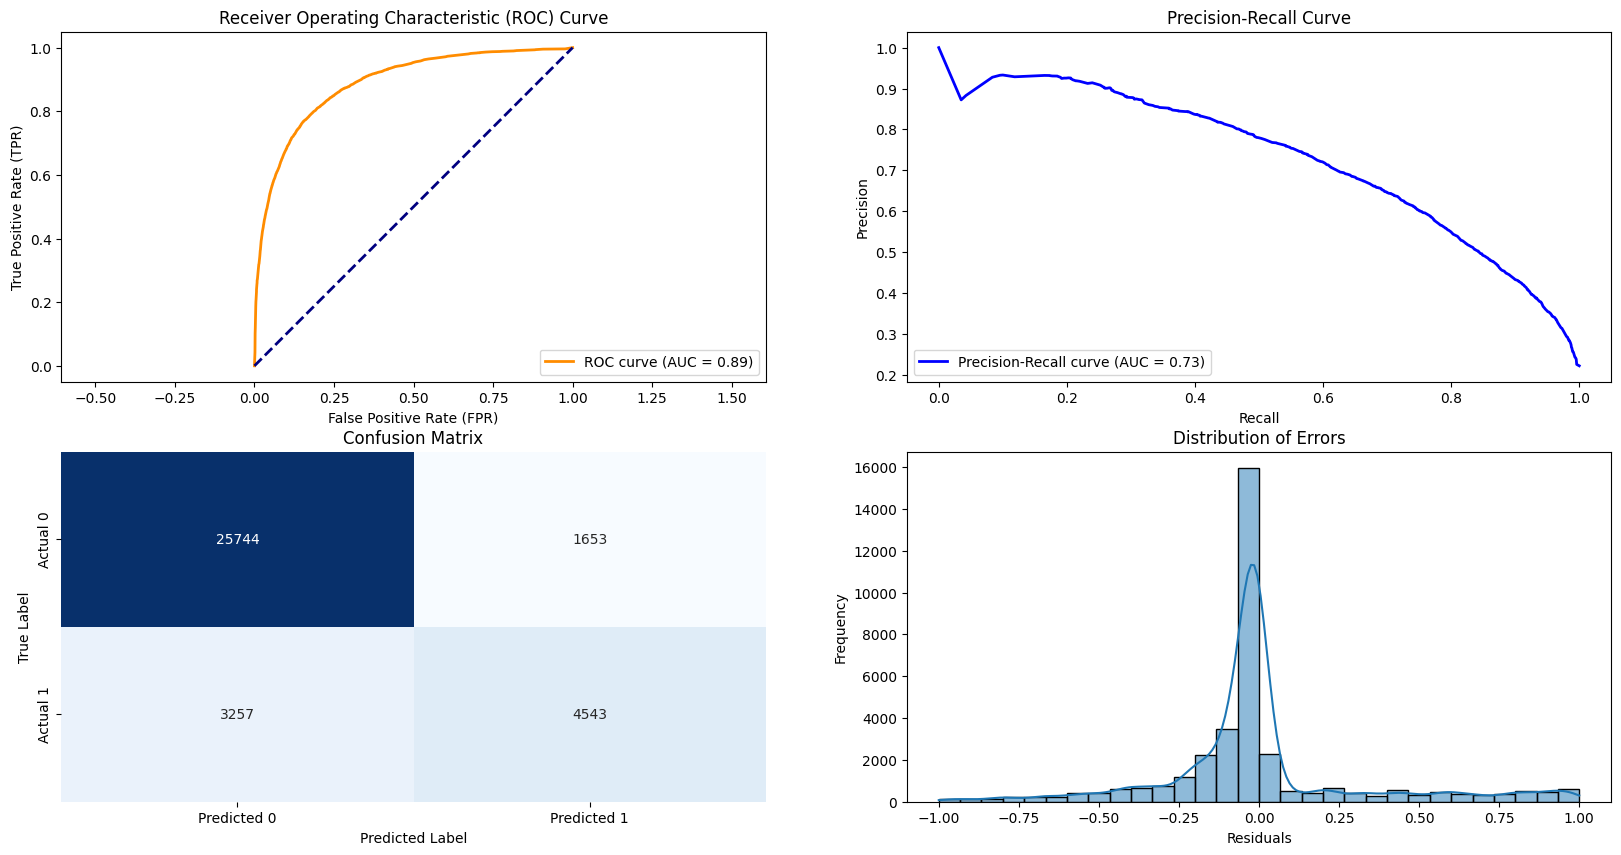

In [247]:
model = Model(best_dt_model, 
              name='DT No Resample', 
              scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [248]:
metrics_DT_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_DT_no_resample.to_frame().T])
print(metrics_DT_no_resample)

Accuracy                                 0.860499
Precision                                0.733215
Recall                                   0.582436
F1-Score                                 0.649185
ROC AUC                                  0.887076
Confusion Matrix    [[25744, 1653], [3257, 4543]]
PR AUC                                   0.727199
Name                               DT No Resample
dtype: object


### SMOTE

In [249]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_smote_scaled, y_train_smote)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   5.0s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   5.0s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   5.2s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   5.3s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   4.5s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   4.8s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   4.9s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; t

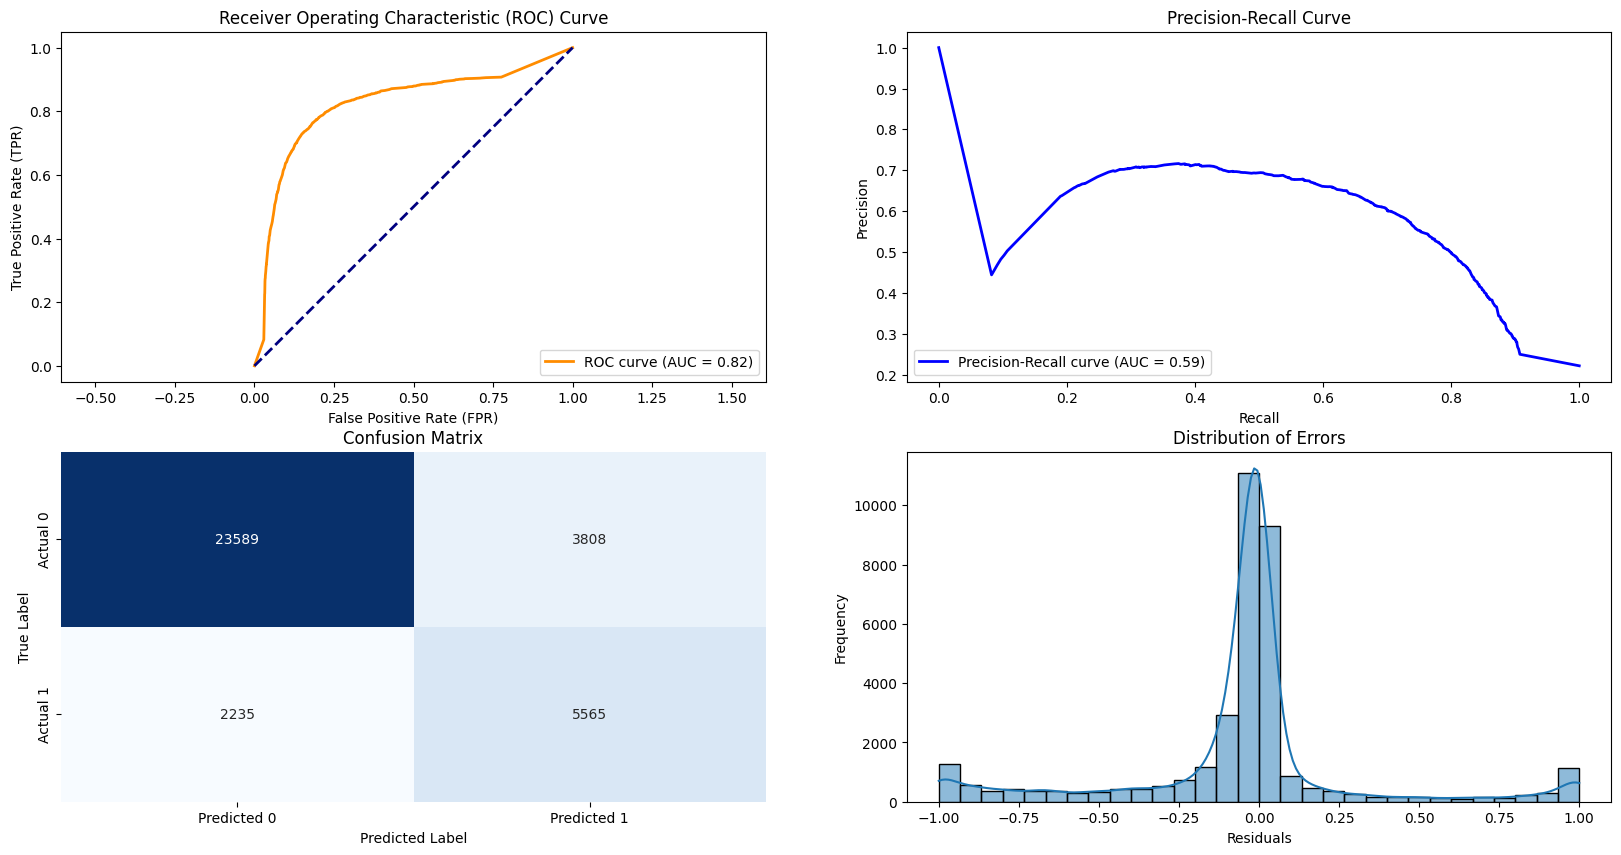

In [250]:
model = Model(best_dt_model, 'DT Smote', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [251]:
metrics_DT_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_DT_smote.to_frame().T])
print(metrics_DT_smote)

Accuracy                                 0.828309
Precision                                0.593727
Recall                                   0.713462
F1-Score                                  0.64811
ROC AUC                                  0.821544
Confusion Matrix    [[23589, 3808], [2235, 5565]]
PR AUC                                   0.567173
Name                                     DT Smote
dtype: object


### Undersample

In [252]:
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 40),
    'min_samples_leaf': randint(1, 20),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None]
}

dt = DecisionTreeClassifier(random_state=42)

random_search = RandomizedSearchCV(dt, param_distributions=param_dist, 
                                   n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)


random_search.fit(X_train_under_scaled, y_train_under)
best_dt_model = random_search.best_estimator_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   1.6s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   1.5s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   1.6s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   1.8s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   1.0s
[CV] END criterion=gini, max_depth=15, max_features=None, min_samples_leaf=8, min_samples_split=22; total time=   1.0s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   1.0s
[CV] END criterion=gini, max_depth=19, max_features=None, min_samples_leaf=11, min_samples_split=12; total time=   1.0s
[CV] END criterion=entropy, max_depth=4, max_

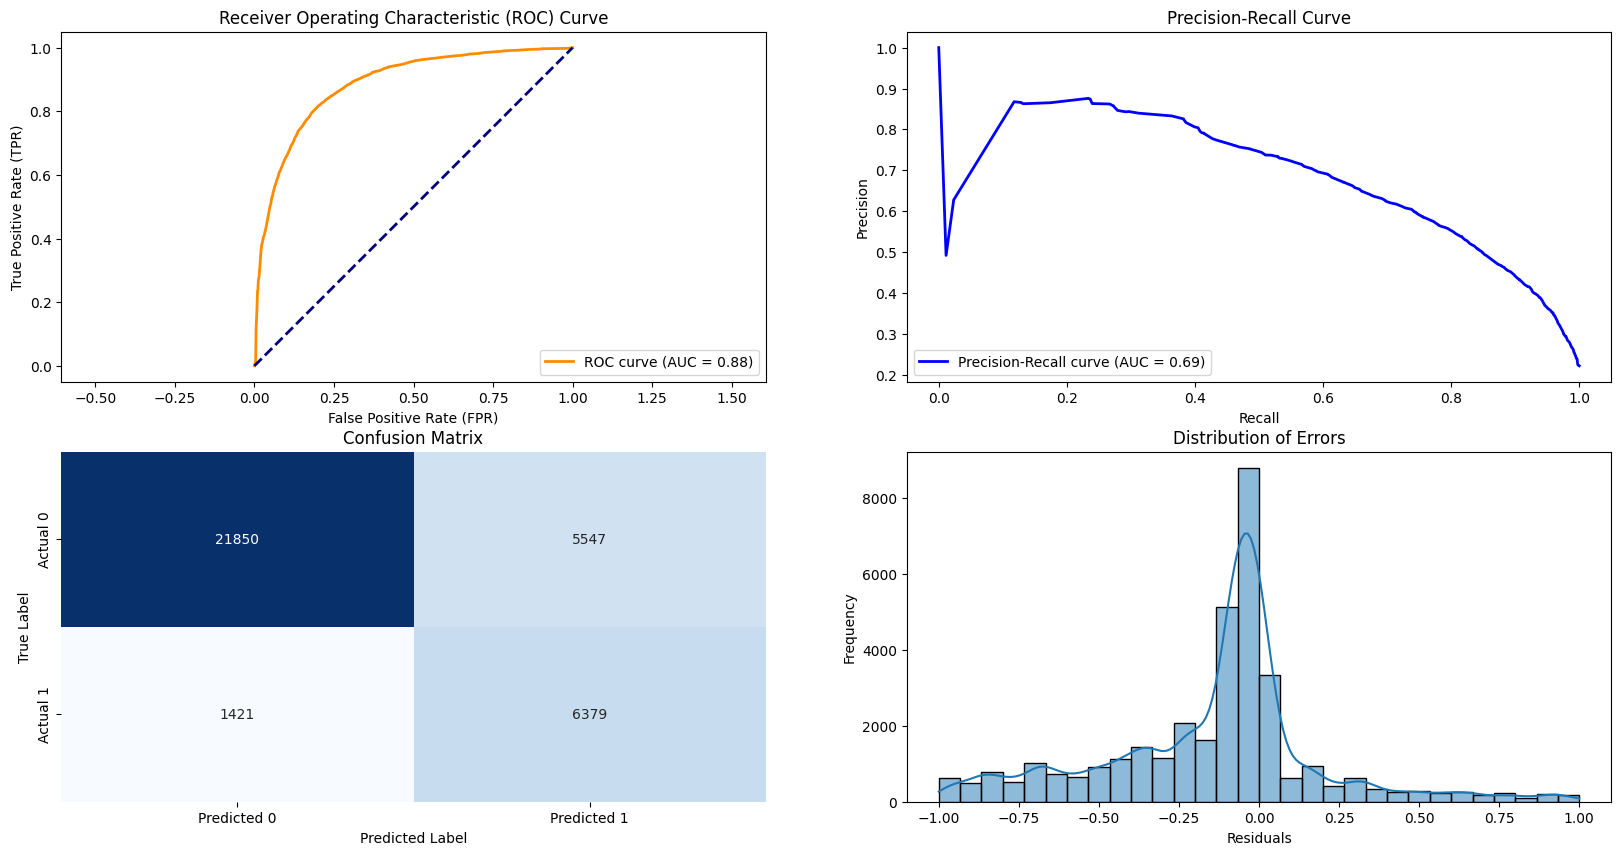

In [253]:
model = Model(best_dt_model, name='DT Undersample', scaled=False, resample='under')
model.fit()
model.visualize_metrics()

In [254]:
metrics_DT_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_DT_under.to_frame().T])
print(metrics_DT_under)

Accuracy                                 0.802029
Precision                                0.534882
Recall                                   0.817821
F1-Score                                 0.646761
ROC AUC                                  0.883984
Confusion Matrix    [[21850, 5547], [1421, 6379]]
PR AUC                                   0.693253
Name                               DT Undersample
dtype: object


## KNN

### No Resample

In [255]:
param_grid = {
    'n_neighbors': list(range(1, 10)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
knn = KNeighborsClassifier()
random_search = RandomizedSearchCV(knn, param_distributions=param_grid, 
                                   n_iter=10, scoring='accuracy', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)
best_knn_model = random_search.best_estimator_

KeyboardInterrupt: 

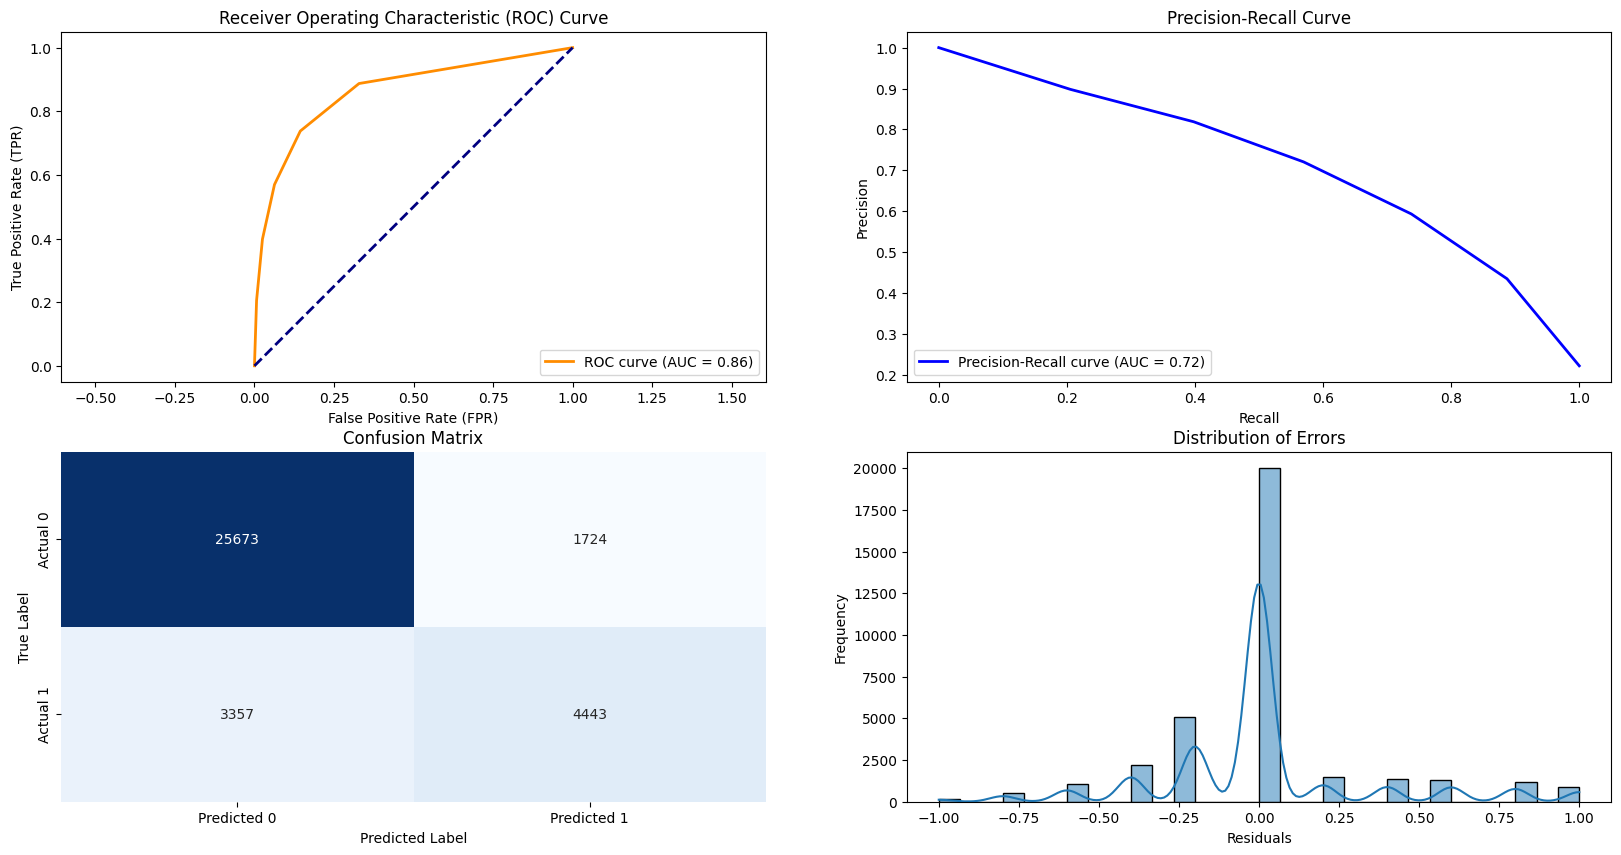

In [256]:
model = Model(KNeighborsClassifier(),'KNN No Resample', scaled=True, resample = None)
model.fit()
model.visualize_metrics()

In [257]:
metrics_KNN_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_KNN_no_resample.to_frame().T])
print(metrics_KNN_no_resample)

Accuracy                                 0.855641
Precision                                0.720448
Recall                                   0.569615
F1-Score                                 0.636214
ROC AUC                                  0.861046
Confusion Matrix    [[25673, 1724], [3357, 4443]]
PR AUC                                   0.655434
Name                              KNN No Resample
dtype: object


### SMOTE

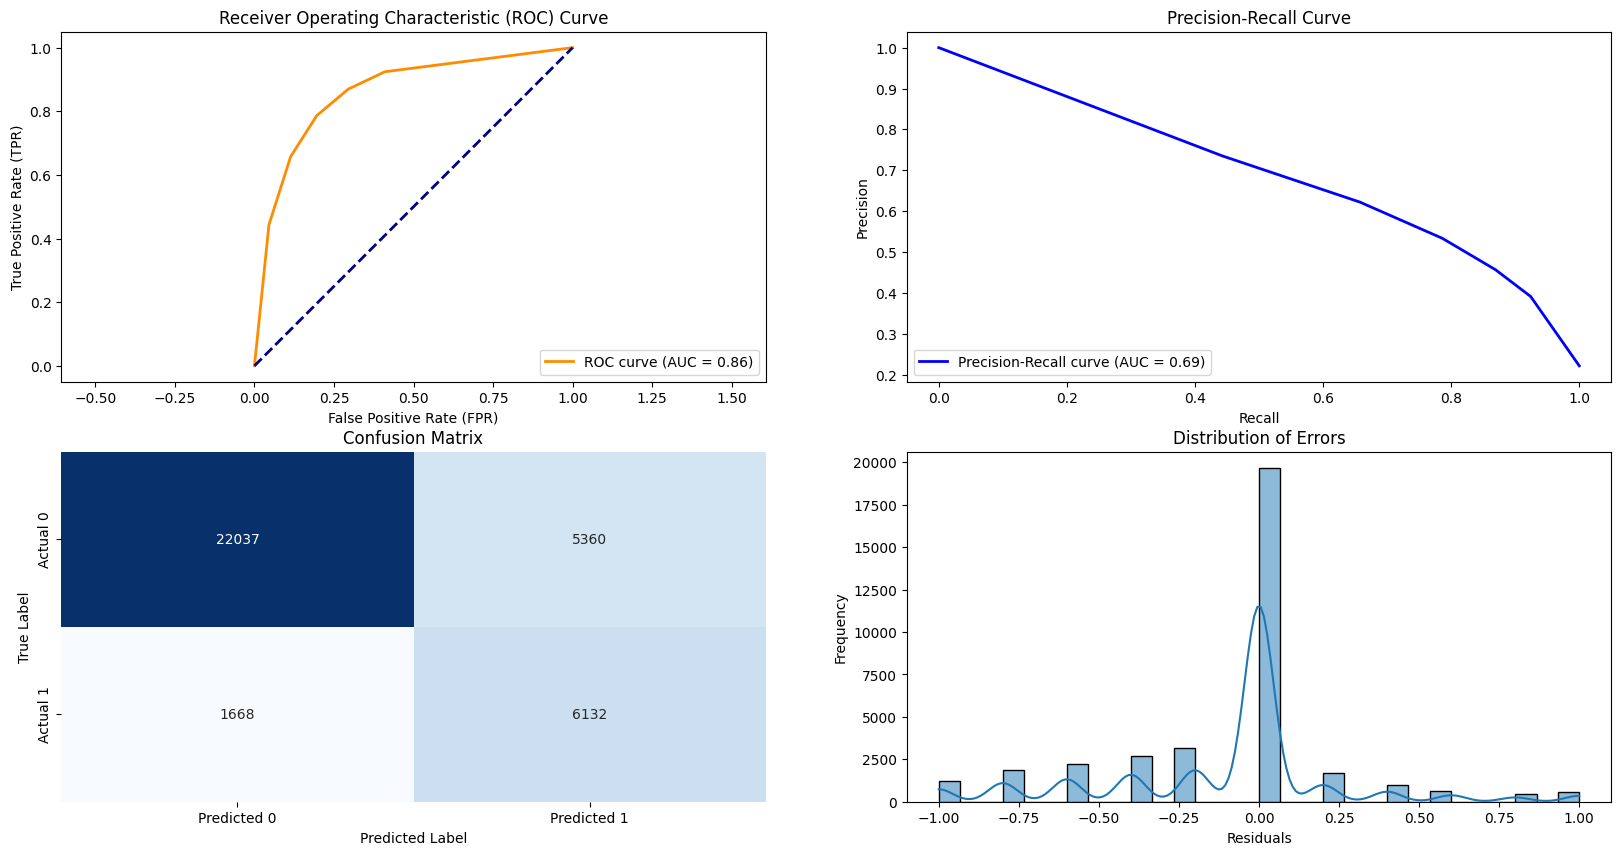

In [258]:
model = Model(KNeighborsClassifier(),'KNN SMOTE', scaled=True, resample = 'smote')
model.fit()
model.visualize_metrics()

In [259]:
metrics_KNN_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_KNN_smote.to_frame().T])
print(metrics_KNN_smote)

Accuracy                                 0.800324
Precision                                0.533589
Recall                                   0.786154
F1-Score                                 0.635704
ROC AUC                                  0.859808
Confusion Matrix    [[22037, 5360], [1668, 6132]]
PR AUC                                    0.60389
Name                                    KNN SMOTE
dtype: object


### Undersample

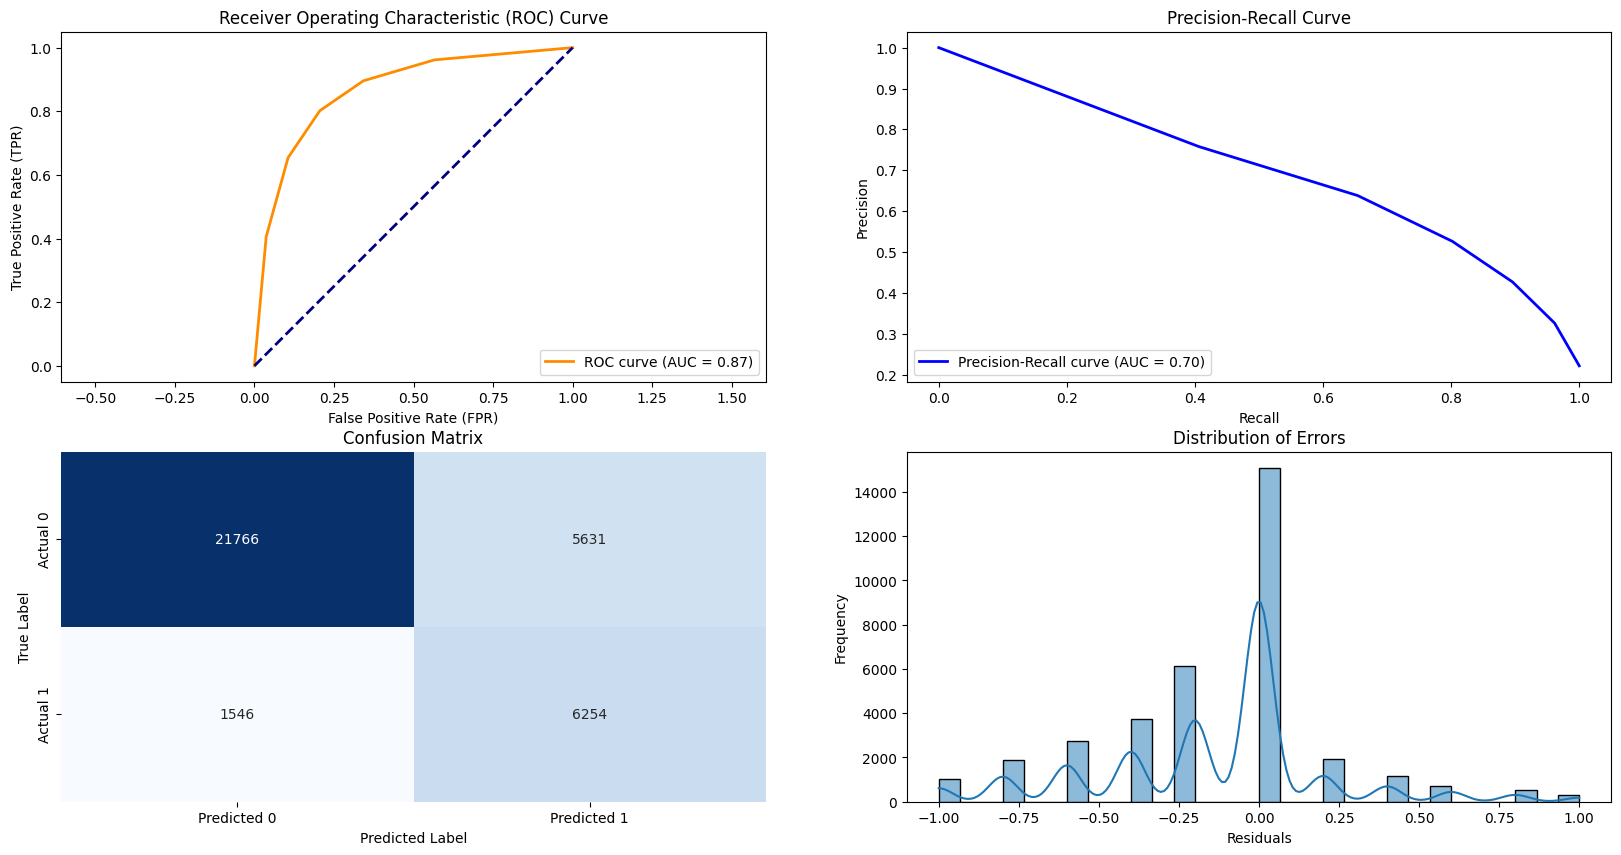

In [260]:
model = Model(KNeighborsClassifier(),'KNN Undersample', scaled=True, resample = 'under')
model.fit()
model.visualize_metrics()

In [261]:
metrics_KNN_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_KNN_under.to_frame().T])
print(metrics_KNN_under)

Accuracy                                 0.796091
Precision                                 0.52621
Recall                                   0.801795
F1-Score                                 0.635408
ROC AUC                                  0.866117
Confusion Matrix    [[21766, 5631], [1546, 6254]]
PR AUC                                   0.613828
Name                              KNN Undersample
dtype: object


## XGBoost

### No Resample

In [262]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Numero di alberi
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasso di apprendimento
    'max_depth': [3, 5, 7, 9],  # Profondità massima degli alberi
    'subsample': [0.6, 0.8, 1.0],  # Campione di dati utilizzato per ogni albero
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentuale di caratteristiche usate per albero
    'gamma': [0, 0.1, 0.2, 0.3],  # Complessità minima di split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularization
}

# Configura il modello
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Numero di combinazioni casuali da testare
    scoring='roc_auc',  # Usa ROC AUC per la valutazione
    cv=4,  # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usa tutti i processori disponibili
)
# Fitta il modello
random_search.fit(X_train_scaled, y_train)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


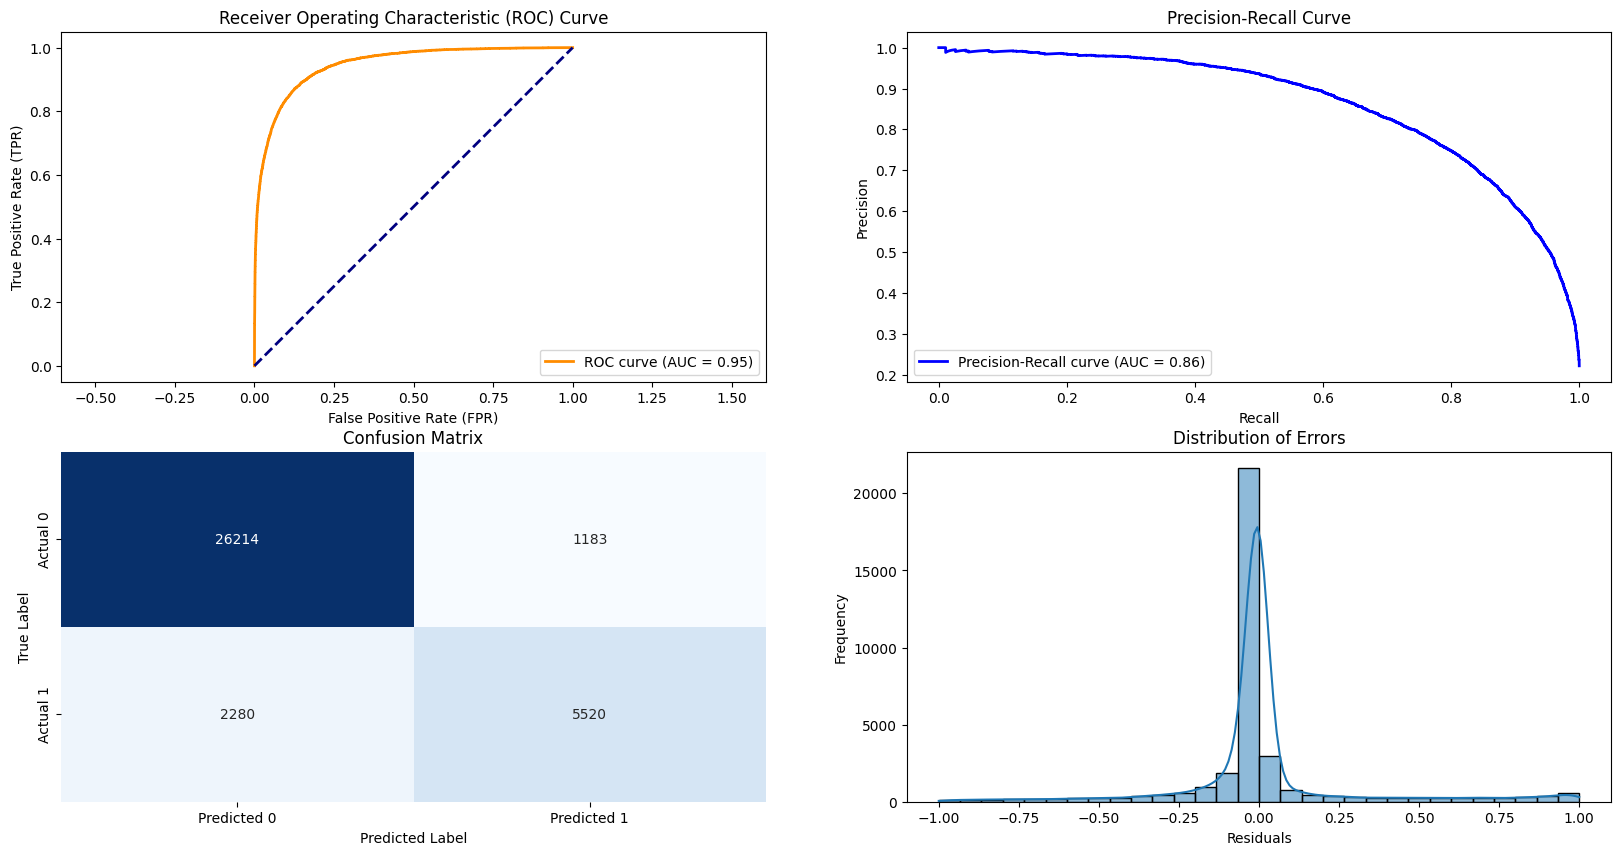

In [263]:
model = Model(best_xgb_model, name='XGB No Resample',
               scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [264]:
metrics_XG_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_XG_no_resample.to_frame().T])
print(metrics_XG_no_resample)

Accuracy                                 0.901611
Precision                                0.823512
Recall                                   0.707692
F1-Score                                 0.761222
ROC AUC                                  0.945631
Confusion Matrix    [[26214, 1183], [2280, 5520]]
PR AUC                                   0.861717
Name                              XGB No Resample
dtype: object


### SMOTE

In [265]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Numero di alberi
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasso di apprendimento
    'max_depth': [3, 5, 7, 9],  # Profondità massima degli alberi
    'subsample': [0.6, 0.8, 1.0],  # Campione di dati utilizzato per ogni albero
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentuale di caratteristiche usate per albero
    'gamma': [0, 0.1, 0.2, 0.3],  # Complessità minima di split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularization
}

# Configura il modello
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Numero di combinazioni casuali da testare
    scoring='roc_auc',  # Usa ROC AUC per la valutazione
    cv=4,  # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usa tutti i processori disponibili
)
# Fitta il modello
random_search.fit(X_train_smote_scaled, y_train_smote)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


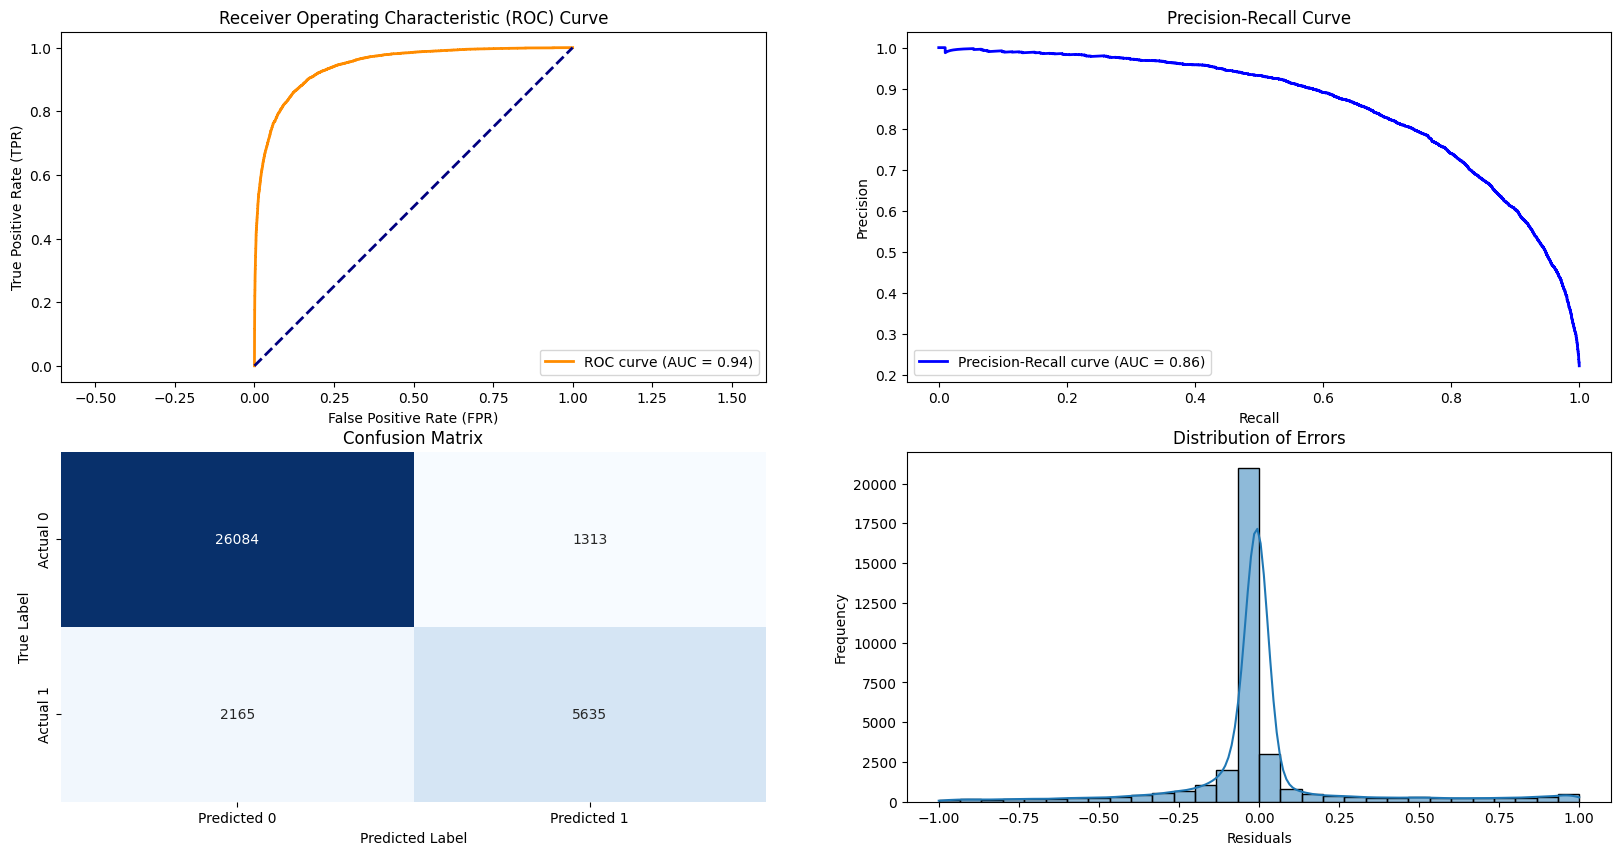

In [266]:
model = Model(best_xgb_model, name='XGB Smote',
               scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [267]:
metrics_XG_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_XG_smote.to_frame().T])
print(metrics_XG_smote)

Accuracy                                 0.901185
Precision                                0.811025
Recall                                   0.722436
F1-Score                                 0.764171
ROC AUC                                  0.943458
Confusion Matrix    [[26084, 1313], [2165, 5635]]
PR AUC                                   0.858693
Name                                    XGB Smote
dtype: object


### Undersample

In [268]:
param_dist = {
    'n_estimators': [50, 100, 200, 300],  # Numero di alberi
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Tasso di apprendimento
    'max_depth': [3, 5, 7, 9],  # Profondità massima degli alberi
    'subsample': [0.6, 0.8, 1.0],  # Campione di dati utilizzato per ogni albero
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentuale di caratteristiche usate per albero
    'gamma': [0, 0.1, 0.2, 0.3],  # Complessità minima di split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularization
}

# Configura il modello
xgb_model = XGBClassifier(objective='binary:logistic', use_label_encoder=False)

# Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Numero di combinazioni casuali da testare
    scoring='roc_auc',  # Usa ROC AUC per la valutazione
    cv=4,  # 3-fold cross validation
    verbose=1,
    random_state=42,
    n_jobs=-1  # Usa tutti i processori disponibili
)
# Fitta il modello
random_search.fit(X_train_under_scaled, y_train_under)
best_xgb_model = random_search.best_estimator_

Fitting 4 folds for each of 50 candidates, totalling 200 fits


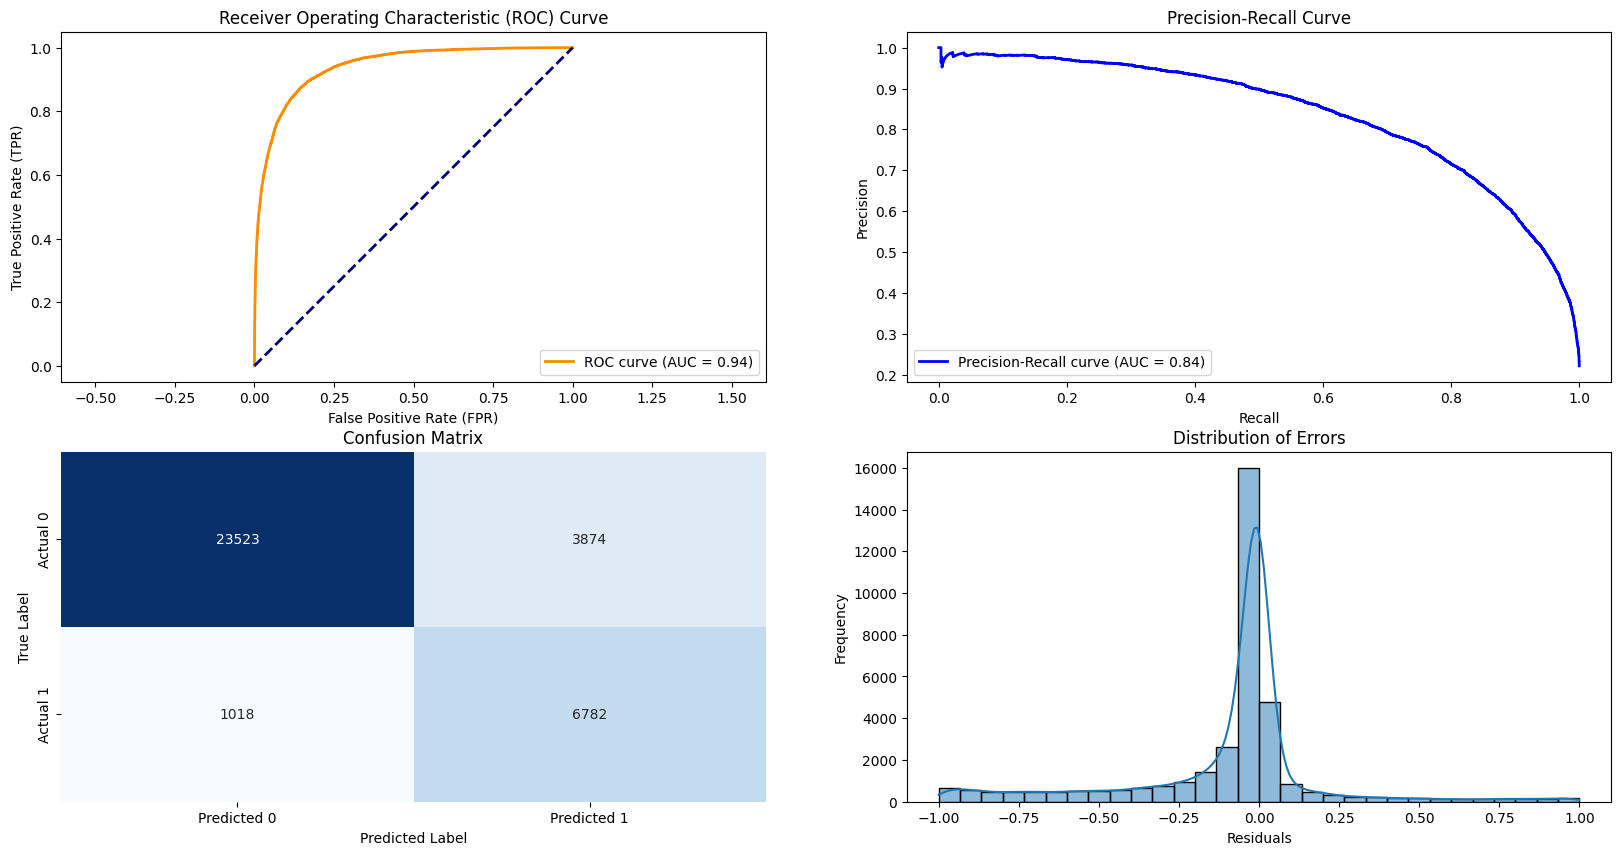

In [269]:
model = Model(best_xgb_model, name='XGB Undersample',
               scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [270]:
metrics_XG_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_XG_under.to_frame().T])
print(metrics_XG_under)

Accuracy                                 0.861011
Precision                                0.636449
Recall                                   0.869487
F1-Score                                 0.734937
ROC AUC                                  0.939268
Confusion Matrix    [[23523, 3874], [1018, 6782]]
PR AUC                                   0.837919
Name                              XGB Undersample
dtype: object


## Gradient Boosting

### No Resample

In [271]:
from scipy.stats import uniform

# Definizione dei parametri per la ricerca casuale
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),  # Valori casuali tra 0.01 e 0.31
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

# Definizione del modello Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV con 10 iterazioni e 3 fold di cross-validation
random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit del modello
random_search.fit(X_train_scaled, y_train)
best_gb_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  14.8s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  14.8s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  14.9s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  33.7s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  33.4s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  33.5s
[CV

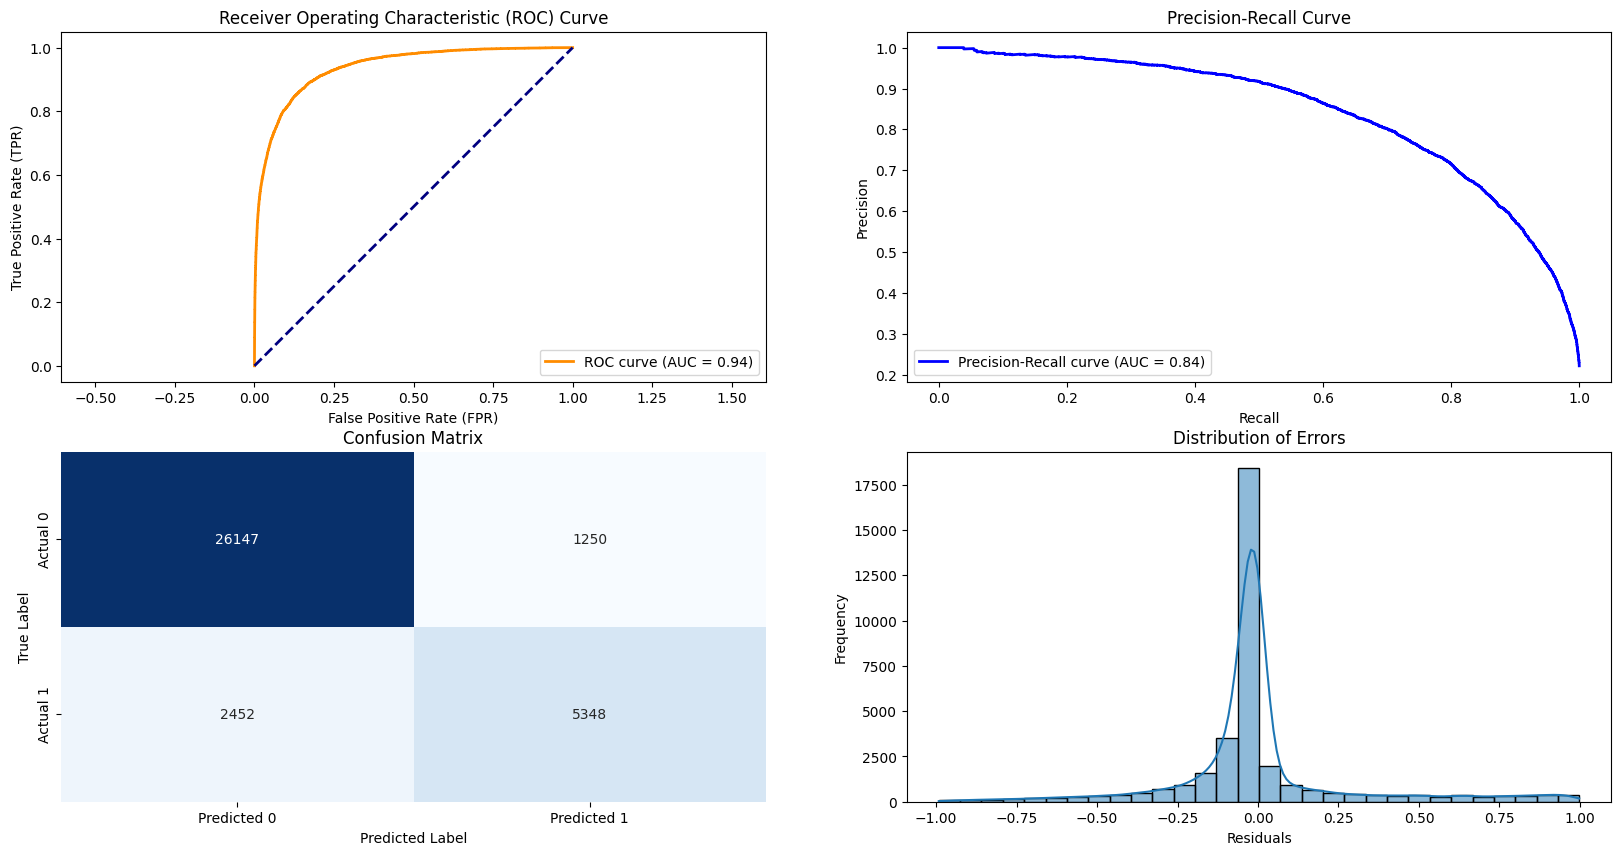

In [272]:
model = Model(best_gb_model, name='Gradient Boosting No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [273]:
metrics_GBC_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_GBC_no_resample.to_frame().T])
print(metrics_GBC_no_resample)

Accuracy                                 0.894821
Precision                                0.810549
Recall                                   0.685641
F1-Score                                 0.742881
ROC AUC                                  0.936303
Confusion Matrix    [[26147, 1250], [2452, 5348]]
PR AUC                                   0.841718
Name                Gradient Boosting No Resample
dtype: object


### SMOTE

In [274]:
# Definizione dei parametri per la ricerca casuale
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),  # Valori casuali tra 0.01 e 0.31
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

# Definizione del modello Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV con 10 iterazioni e 3 fold di cross-validation
random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit del modello
random_search.fit(X_train_smote_scaled, y_train_smote)
best_gb_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  29.2s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  29.5s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=  35.3s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time= 1.3min
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time= 1.1min
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time= 1.1min
[CV

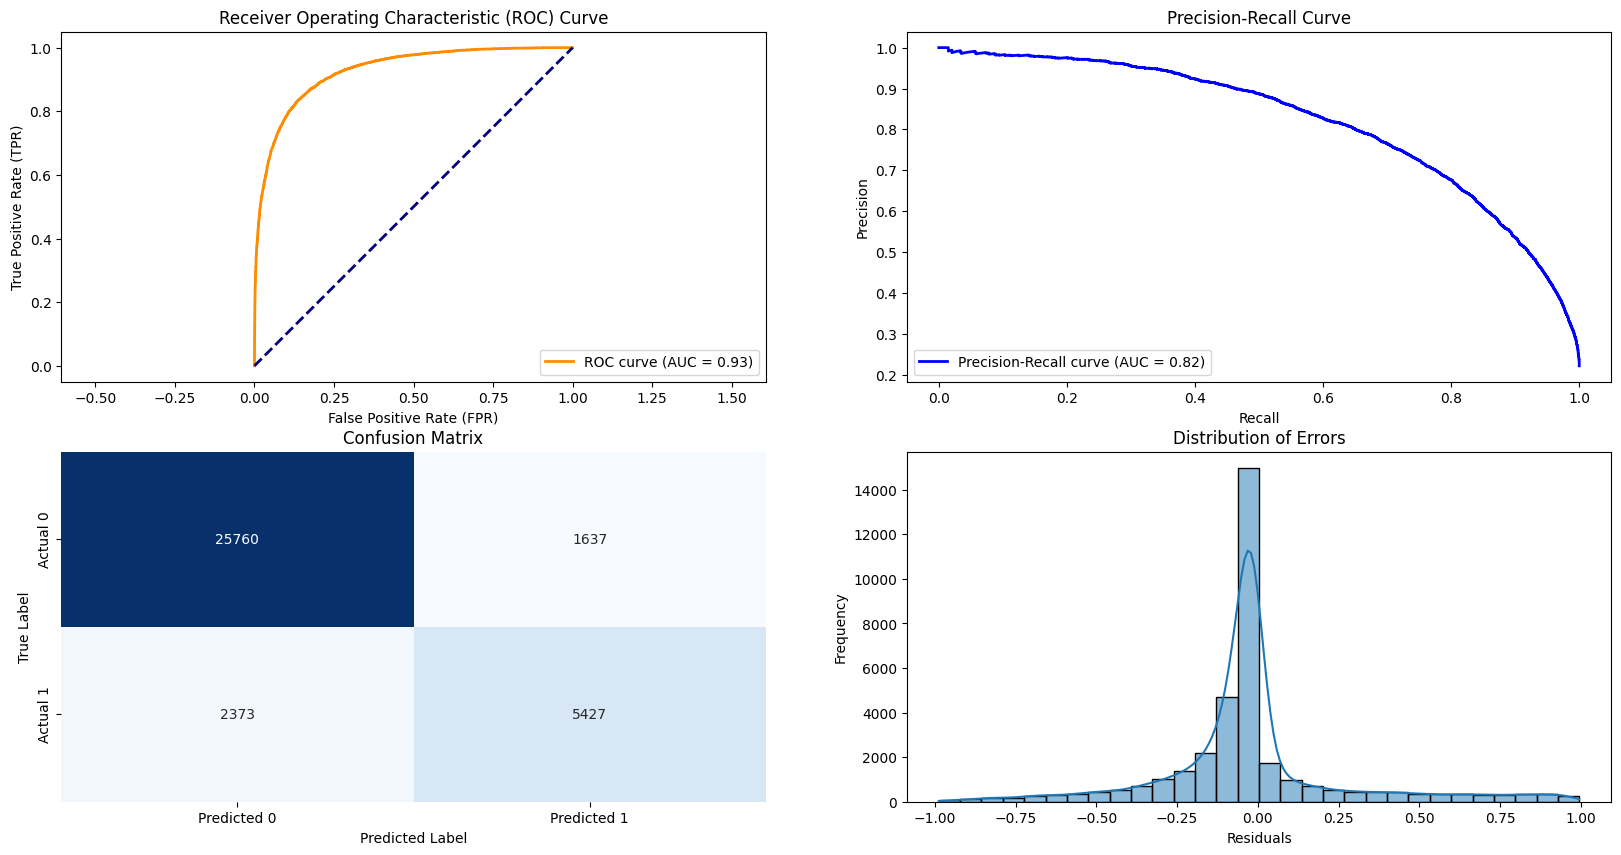

In [275]:
model = Model(best_gb_model, name='Gradient Boosting SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [276]:
metrics_GBC_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_GBC_smote.to_frame().T])
print(metrics_GBC_smote)

Accuracy                                  0.88607
Precision                                0.768262
Recall                                   0.695769
F1-Score                                 0.730221
ROC AUC                                  0.926696
Confusion Matrix    [[25760, 1637], [2373, 5427]]
PR AUC                                   0.819595
Name                      Gradient Boosting SMOTE
dtype: object


### Undersample

In [277]:
# Definizione dei parametri per la ricerca casuale
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.3),  # Valori casuali tra 0.01 e 0.31
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 40],
    'min_samples_leaf': [20, 50, 70],
    'max_features': ['sqrt', 'log2']
}

# Definizione del modello Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# RandomizedSearchCV con 10 iterazioni e 3 fold di cross-validation
random_search = RandomizedSearchCV(gb, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Fit del modello
random_search.fit(X_train_under_scaled, y_train_under)
best_gb_model = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=   5.8s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=   5.9s
[CV] END learning_rate=0.12236203565420874, max_depth=3, max_features=sqrt, min_samples_leaf=70, min_samples_split=10, n_estimators=100; total time=   5.9s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  13.6s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  14.0s
[CV] END learning_rate=0.05680559213273095, max_depth=7, max_features=sqrt, min_samples_leaf=70, min_samples_split=40, n_estimators=100; total time=  14.0s
[CV

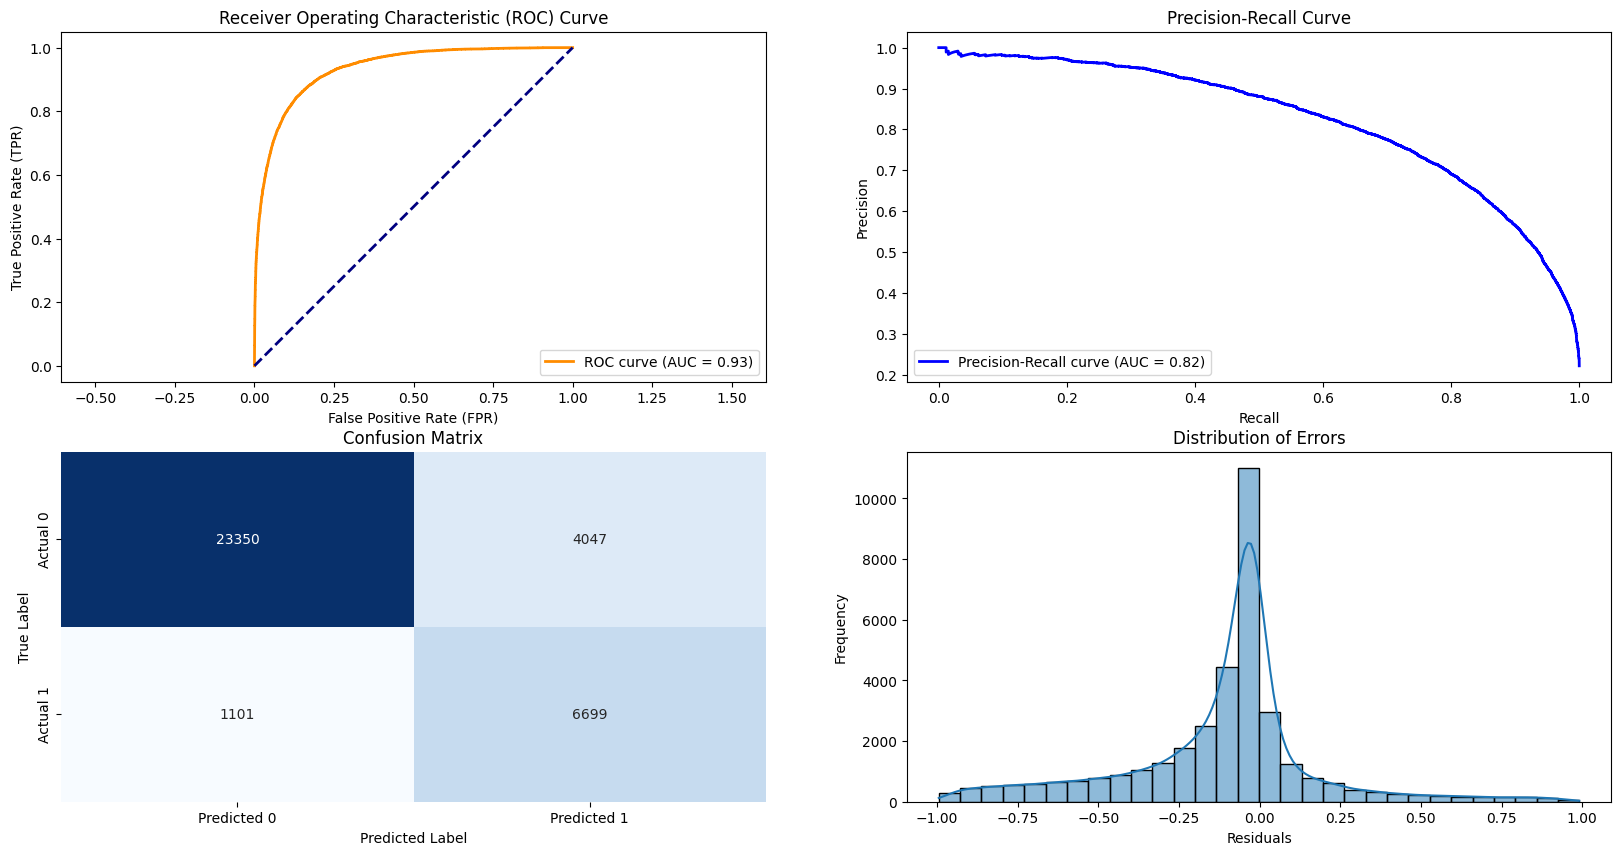

In [278]:
model = Model(best_gb_model, name='Gradient Boosting Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [279]:
metrics_GBC_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_GBC_under.to_frame().T])
print(metrics_GBC_under)

Accuracy                                 0.853738
Precision                                0.623395
Recall                                   0.858846
F1-Score                                  0.72242
ROC AUC                                  0.932756
Confusion Matrix    [[23350, 4047], [1101, 6699]]
PR AUC                                   0.824284
Name                Gradient Boosting Undersample
dtype: object


## Random Forest

### No Resample

In [181]:
# Definire l'intervallo di parametri da esplorare
param_dist = {
    'n_estimators': [100, 200, 300],  # Numero di alberi nella foresta
    'max_depth': [10, 20, 30, None],  # Profondità massima degli alberi
    'min_samples_split': [2, 5, 10],  # Numero minimo di campioni per effettuare uno split
    'min_samples_leaf': [1, 2, 4],    # Numero minimo di campioni nelle foglie
    'bootstrap': [True, False]        # Se campionare con sostituzione o meno
}

# Inizializzare il modello Random Forest
rf_model = RandomForestClassifier()

# RandomizedSearchCV per esplorare casualmente i parametri
rf_random_search = RandomizedSearchCV(estimator=rf_model,
                                      param_distributions=param_dist,
                                      n_iter=50,    # Numero di iterazioni da fare
                                      cv=3,         # Numero di folds per cross-validation
                                      verbose=2,    # Per visualizzare il progresso
                                      random_state=42,  # Per riproducibilità
                                      n_jobs=-1)    # Utilizzo di tutti i core del processore

# Eseguire la ricerca
rf_random_search.fit(X_train_scaled, y_train)

# Miglior modello trovato
best_rf_model = rf_random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time= 1.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.0min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  59.1s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  58.8s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time= 1.1min
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100

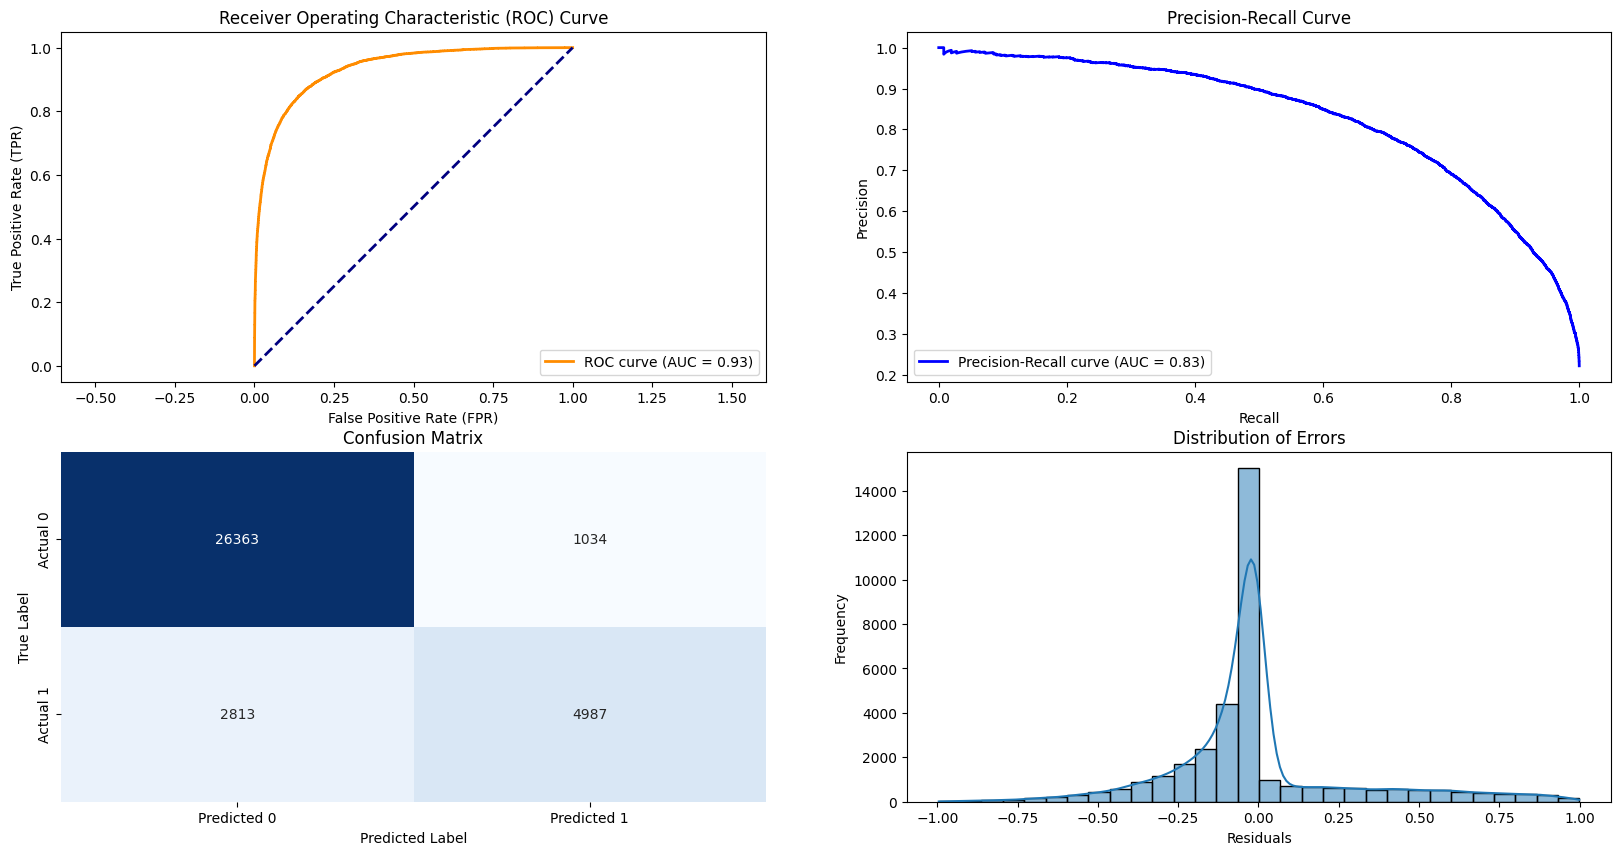

In [280]:
model = Model(best_rf_model, name='RF No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [281]:
metrics_RF_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_RF_no_resample.to_frame().T])
print(metrics_RF_no_resample)

Accuracy                                 0.890701
Precision                                0.828268
Recall                                   0.639359
F1-Score                                 0.721655
ROC AUC                                   0.93264
Confusion Matrix    [[26363, 1034], [2813, 4987]]
PR AUC                                   0.829919
Name                               RF No Resample
dtype: object


### SMOTE

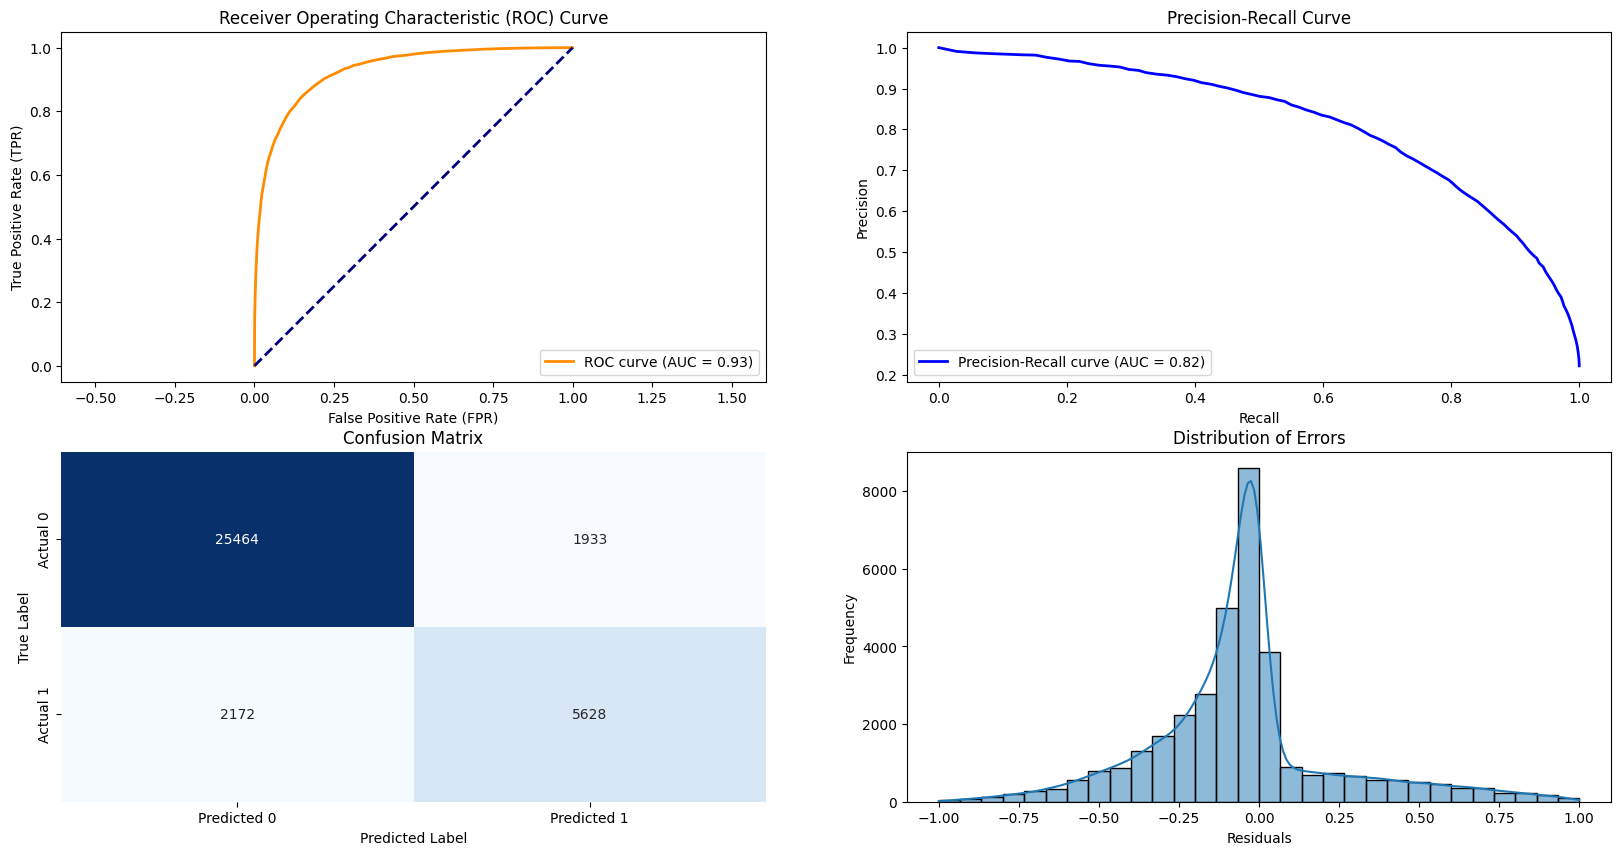

In [282]:
model = Model(RandomForestClassifier(), name='RF SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [283]:
metrics_RF_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_RF_smote.to_frame().T])
print(metrics_RF_smote)

Accuracy                                 0.883371
Precision                                0.744346
Recall                                   0.721538
F1-Score                                 0.732765
ROC AUC                                  0.927489
Confusion Matrix    [[25464, 1933], [2172, 5628]]
PR AUC                                   0.815336
Name                                     RF SMOTE
dtype: object


### Undersample

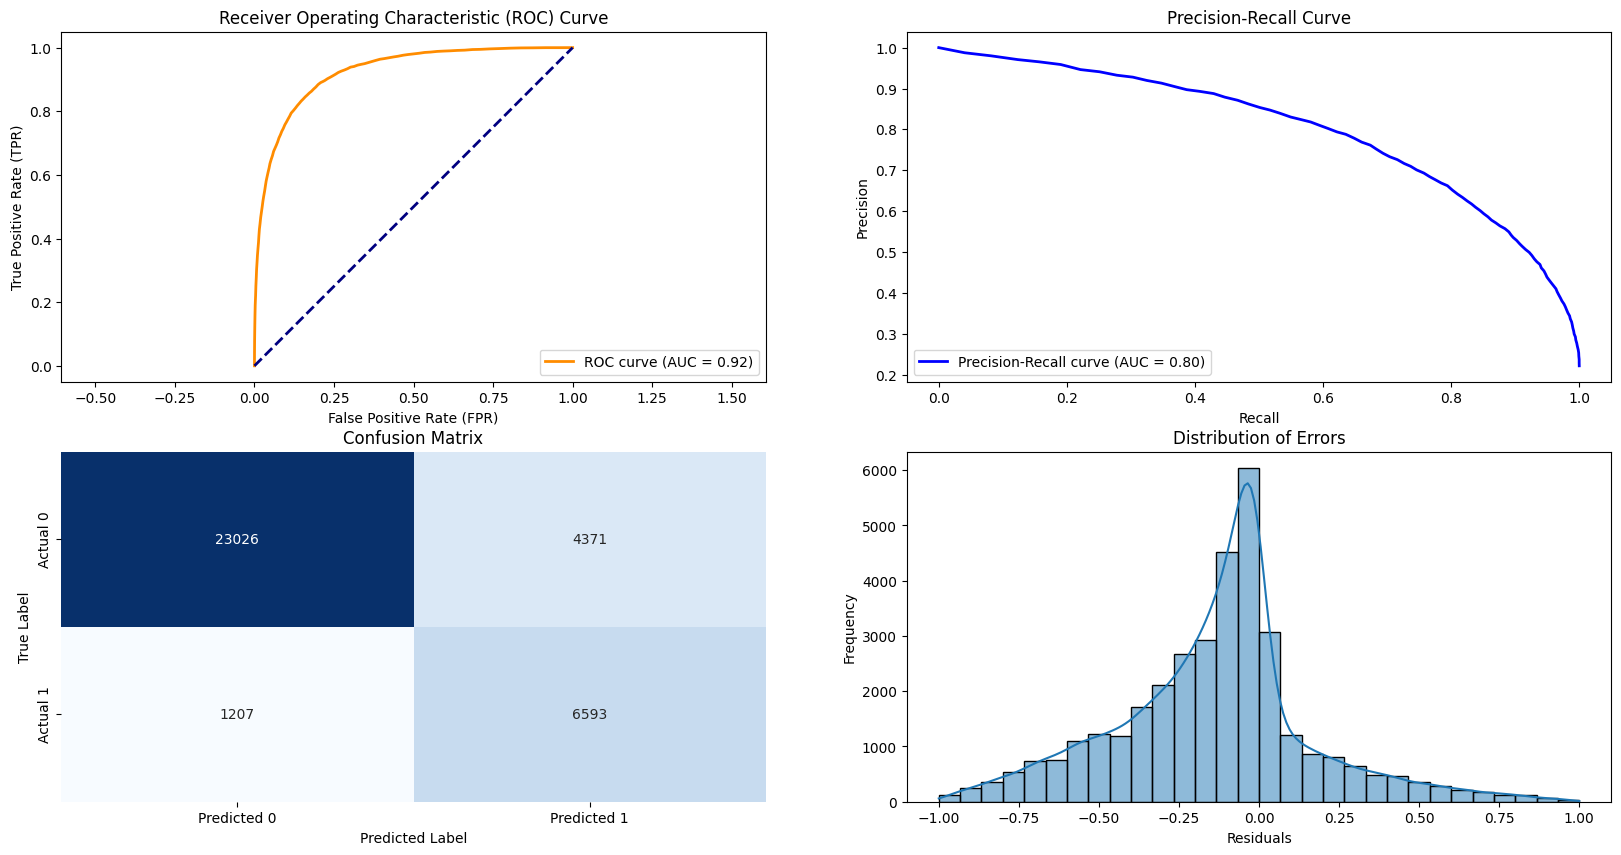

In [284]:
model = Model(RandomForestClassifier(), name='RF Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [285]:
metrics_RF_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_RF_under.to_frame().T])
print(metrics_RF_under)

Accuracy                                 0.841521
Precision                                0.601332
Recall                                   0.845256
F1-Score                                 0.702729
ROC AUC                                  0.923079
Confusion Matrix    [[23026, 4371], [1207, 6593]]
PR AUC                                   0.796929
Name                               RF Undersample
dtype: object


## CatBoost

### No Resample

In [188]:
model = cb.CatBoostClassifier()
grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10]
}
grid_search = GridSearchCV(model, grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), verbose=100)

0:	learn: 0.6150974	test: 0.6149742	best: 0.6149742 (0)	total: 164ms	remaining: 1m 21s
0:	learn: 0.6840978	test: 0.6841228	best: 0.6841228 (0)	total: 166ms	remaining: 1m 22s
0:	learn: 0.6840674	test: 0.6840758	best: 0.6840758 (0)	total: 178ms	remaining: 1m 28s
0:	learn: 0.6847430	test: 0.6847357	best: 0.6847357 (0)	total: 194ms	remaining: 1m 36s
100:	learn: 0.2933057	test: 0.2993230	best: 0.2993230 (100)	total: 7.52s	remaining: 29.7s
100:	learn: 0.3743380	test: 0.3751485	best: 0.3751485 (100)	total: 7.6s	remaining: 30s
100:	learn: 0.3770675	test: 0.3765363	best: 0.3765363 (100)	total: 7.65s	remaining: 30.2s
100:	learn: 0.3740444	test: 0.3752416	best: 0.3752416 (100)	total: 7.65s	remaining: 30.2s
200:	learn: 0.3351360	test: 0.3371428	best: 0.3371428 (200)	total: 16.7s	remaining: 24.9s
200:	learn: 0.2660914	test: 0.2810000	best: 0.2810000 (200)	total: 16.8s	remaining: 25.1s
200:	learn: 0.3379106	test: 0.3377105	best: 0.3377105 (200)	total: 17s	remaining: 25.3s
200:	learn: 0.3348545	test:

GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x13bbb28f0>,
             n_jobs=-1,
             param_grid={'depth': [6, 8, 10], 'iterations': [500, 1000],
                         'learning_rate': [0.01, 0.1, 0.2]},
             scoring='roc_auc')

In [286]:
best_model = grid_search.best_estimator_

0:	learn: 0.6094189	total: 146ms	remaining: 2m 25s
1:	learn: 0.5460740	total: 201ms	remaining: 1m 40s
2:	learn: 0.4967048	total: 264ms	remaining: 1m 27s
3:	learn: 0.4629869	total: 291ms	remaining: 1m 12s
4:	learn: 0.4369540	total: 337ms	remaining: 1m 7s
5:	learn: 0.4145123	total: 593ms	remaining: 1m 38s
6:	learn: 0.3956729	total: 726ms	remaining: 1m 42s
7:	learn: 0.3824085	total: 937ms	remaining: 1m 56s
8:	learn: 0.3714892	total: 1.01s	remaining: 1m 51s
9:	learn: 0.3634372	total: 1.07s	remaining: 1m 46s
10:	learn: 0.3564917	total: 1.21s	remaining: 1m 48s
11:	learn: 0.3498206	total: 1.38s	remaining: 1m 53s
12:	learn: 0.3449021	total: 1.48s	remaining: 1m 52s
13:	learn: 0.3409966	total: 1.6s	remaining: 1m 52s
14:	learn: 0.3377450	total: 1.66s	remaining: 1m 49s
15:	learn: 0.3346044	total: 1.73s	remaining: 1m 46s
16:	learn: 0.3319217	total: 1.81s	remaining: 1m 44s
17:	learn: 0.3293997	total: 1.86s	remaining: 1m 41s
18:	learn: 0.3273835	total: 1.89s	remaining: 1m 37s
19:	learn: 0.3254168	tot

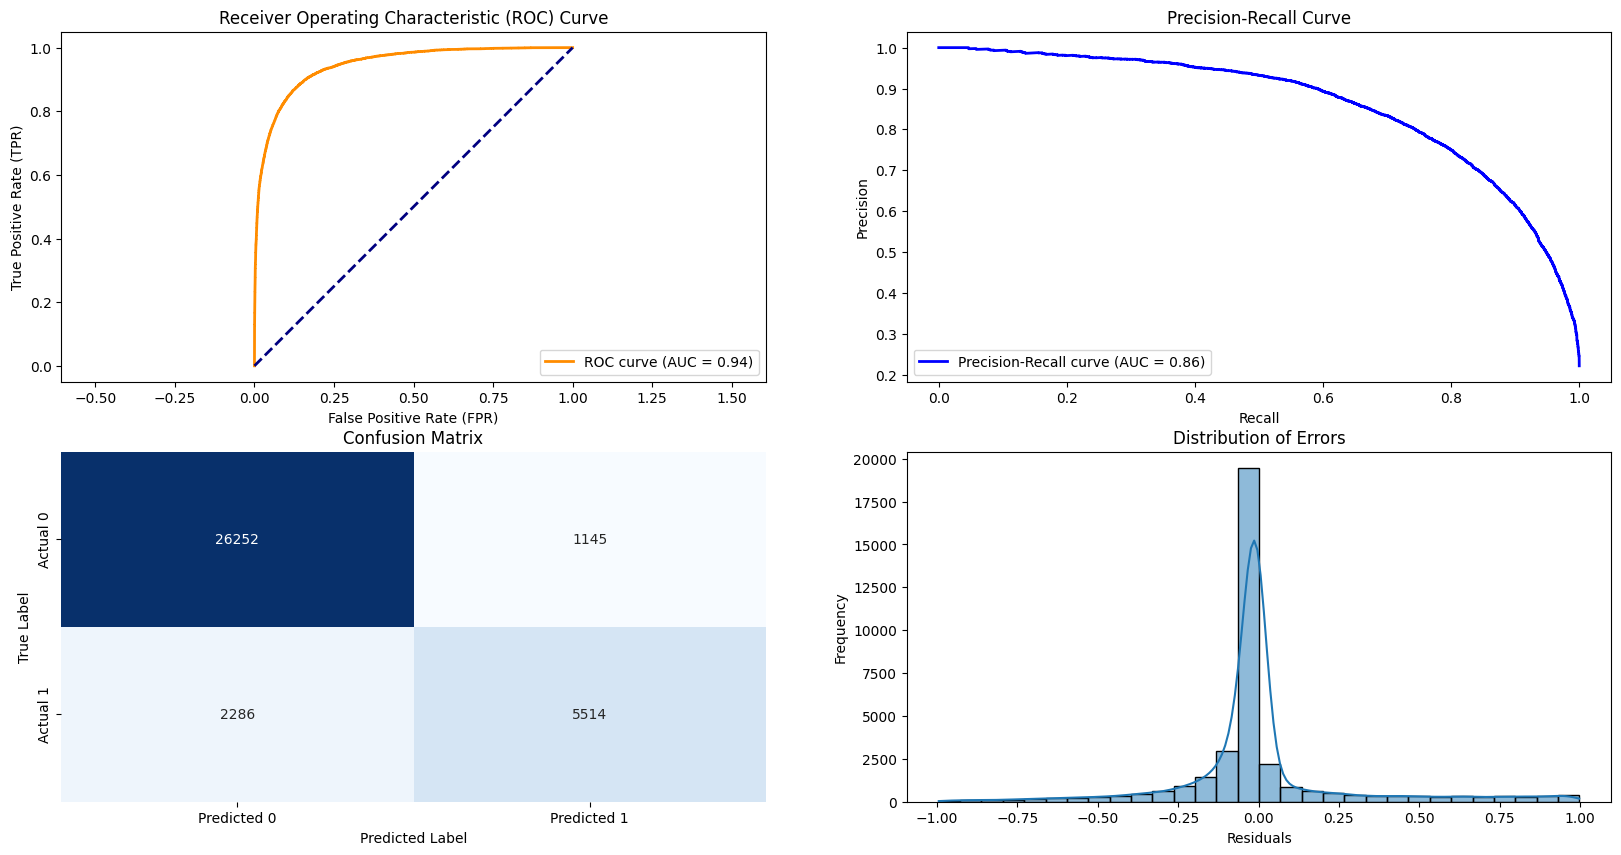

In [287]:
model = Model(best_model, 
              name='CatBoost No Resample', scaled=True, resample=None)
model.fit()
model.visualize_metrics()

In [288]:
metrics_CB_no_resample = model.get_metrics()
models_df = pd.concat([models_df, metrics_CB_no_resample.to_frame().T])
print(metrics_CB_no_resample)

Accuracy                                  0.90252
Precision                                0.828052
Recall                                   0.706923
F1-Score                                 0.762708
ROC AUC                                  0.944877
Confusion Matrix    [[26252, 1145], [2286, 5514]]
PR AUC                                   0.860627
Name                         CatBoost No Resample
dtype: object


### SMOTE

Learning rate set to 0.091012


0:	learn: 0.6170552	total: 321ms	remaining: 5m 20s
1:	learn: 0.5694163	total: 559ms	remaining: 4m 39s
2:	learn: 0.5381588	total: 759ms	remaining: 4m 12s
3:	learn: 0.5109561	total: 910ms	remaining: 3m 46s
4:	learn: 0.4922460	total: 1.11s	remaining: 3m 40s
5:	learn: 0.4690244	total: 1.25s	remaining: 3m 27s
6:	learn: 0.4550615	total: 1.33s	remaining: 3m 8s
7:	learn: 0.4434899	total: 1.4s	remaining: 2m 54s
8:	learn: 0.4339277	total: 1.47s	remaining: 2m 41s
9:	learn: 0.4252950	total: 1.52s	remaining: 2m 30s
10:	learn: 0.4179449	total: 1.6s	remaining: 2m 23s
11:	learn: 0.4115521	total: 1.68s	remaining: 2m 18s
12:	learn: 0.4051883	total: 1.73s	remaining: 2m 11s
13:	learn: 0.3997564	total: 1.78s	remaining: 2m 5s
14:	learn: 0.3952685	total: 1.95s	remaining: 2m 7s
15:	learn: 0.3905852	total: 1.99s	remaining: 2m 2s
16:	learn: 0.3874056	total: 2.04s	remaining: 1m 58s
17:	learn: 0.3838146	total: 2.08s	remaining: 1m 53s
18:	learn: 0.3795785	total: 2.12s	remaining: 1m 49s
19:	learn: 0.3759622	total: 

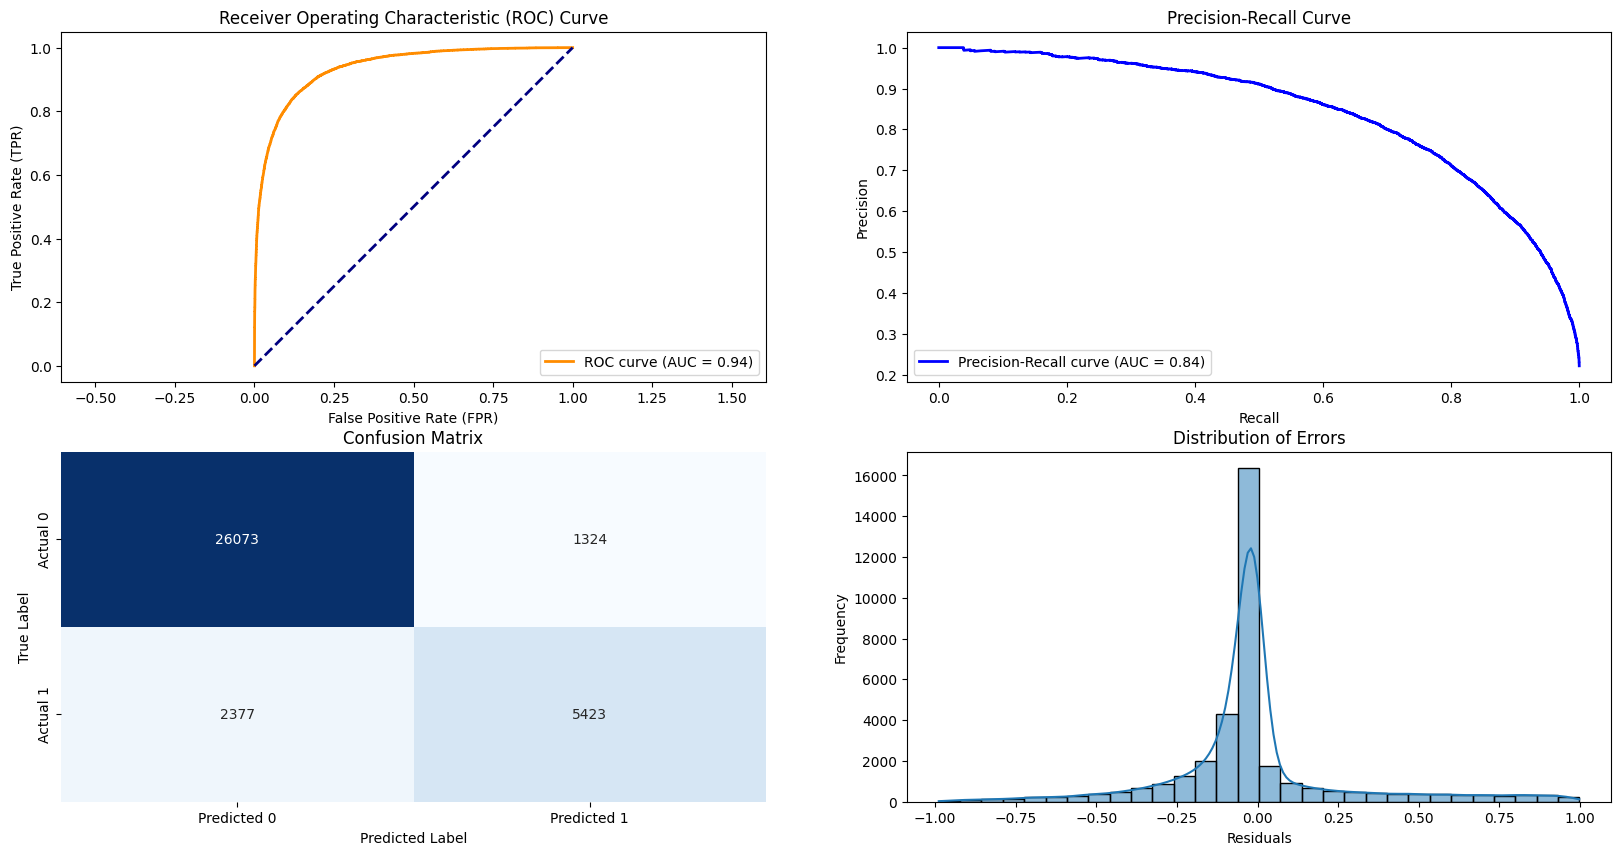

In [289]:
model = Model(cb.CatBoostClassifier(), 
              name='CatBoost SMOTE', scaled=True, resample='smote')
model.fit()
model.visualize_metrics()

In [290]:
metrics_CB_smote = model.get_metrics()
models_df_smote = pd.concat([models_df_smote, metrics_CB_smote.to_frame().T])
print(metrics_CB_smote)

Accuracy                                 0.894849
Precision                                0.803765
Recall                                   0.695256
F1-Score                                 0.745583
ROC AUC                                  0.936532
Confusion Matrix    [[26073, 1324], [2377, 5423]]
PR AUC                                   0.840984
Name                               CatBoost SMOTE
dtype: object


### Undersample

Learning rate set to 0.053228
0:	learn: 0.6636828	total: 99.9ms	remaining: 1m 39s
1:	learn: 0.6389730	total: 133ms	remaining: 1m 6s
2:	learn: 0.6165421	total: 166ms	remaining: 55.1s
3:	learn: 0.5963138	total: 229ms	remaining: 56.9s
4:	learn: 0.5780313	total: 276ms	remaining: 54.9s
5:	learn: 0.5625119	total: 314ms	remaining: 52.1s
6:	learn: 0.5490634	total: 392ms	remaining: 55.6s
7:	learn: 0.5359520	total: 414ms	remaining: 51.3s
8:	learn: 0.5243795	total: 611ms	remaining: 1m 7s
9:	learn: 0.5154347	total: 632ms	remaining: 1m 2s
10:	learn: 0.5068359	total: 689ms	remaining: 1m 1s
11:	learn: 0.4993930	total: 794ms	remaining: 1m 5s
12:	learn: 0.4924877	total: 914ms	remaining: 1m 9s
13:	learn: 0.4863318	total: 956ms	remaining: 1m 7s
14:	learn: 0.4804407	total: 988ms	remaining: 1m 4s
15:	learn: 0.4754286	total: 1.02s	remaining: 1m 2s
16:	learn: 0.4707367	total: 1.03s	remaining: 59.8s
17:	learn: 0.4665726	total: 1.05s	remaining: 57.3s
18:	learn: 0.4629323	total: 1.06s	remaining: 54.9s
19:	learn

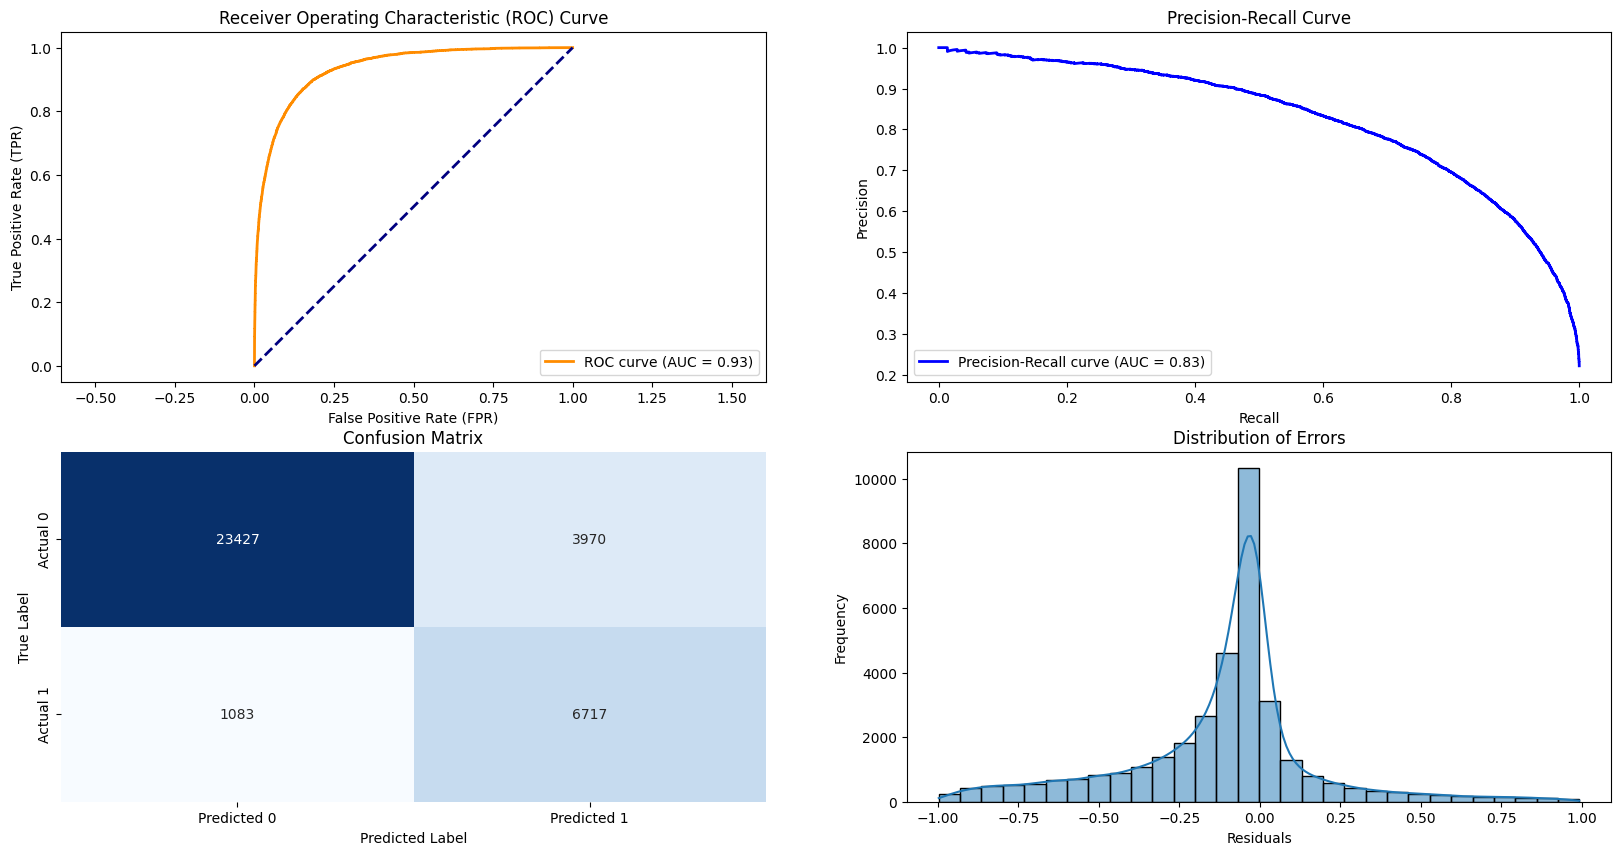

In [291]:
model = Model(cb.CatBoostClassifier(), 
              name='CatBoost Undersample', scaled=True, resample='under')
model.fit()
model.visualize_metrics()

In [292]:
metrics_CB_under = model.get_metrics()
models_df_under = pd.concat([models_df_under, metrics_CB_under.to_frame().T])
print(metrics_CB_under)

Accuracy                                 0.856437
Precision                                0.628521
Recall                                   0.861154
F1-Score                                 0.726673
ROC AUC                                  0.934184
Confusion Matrix    [[23427, 3970], [1083, 6717]]
PR AUC                                   0.826278
Name                         CatBoost Undersample
dtype: object


# Conclusion

## No Resample

In [293]:
models_df

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA No Resample  0.857658  0.719616  0.586026  0.645986   
0  Logistic Regression No Resample   0.85871  0.738324   0.56141  0.637827   
0                   DT No Resample  0.860499  0.733215  0.582436  0.649185   
0                  KNN No Resample  0.855641  0.720448  0.569615  0.636214   
0                  XGB No Resample  0.901611  0.823512  0.707692  0.761222   
0    Gradient Boosting No Resample  0.894821  0.810549  0.685641  0.742881   
0                   RF No Resample  0.890701  0.828268  0.639359  0.721655   
0             CatBoost No Resample   0.90252  0.828052  0.706923  0.762708   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.888372  [[25616, 1781], [3229, 4571]]  0.726621  
0  0.889523  [[25845, 1552], [3421, 4379]]  0.729491  
0  0.887076  [[25744, 1653], [3257, 4543]]  0.727199  
0  0.861046  [[25673, 1724], [3357, 4443]]  0.655434  
0  0.945631  [[26214, 1183], [2280, 5520]]  0.861717  
0  0.936303  [[26147, 1250], [2452, 5348]]  0.841718  
0   0.93264  [[26363, 1034], [2813, 4987]]  0.829919  
0  0.944877  [[26252, 1145], [2286, 5514]]  0.860627

In [294]:
models_df.index = models_df.Name
models_df = models_df.drop('Name',axis=1)

<Axes: xlabel='Name'>

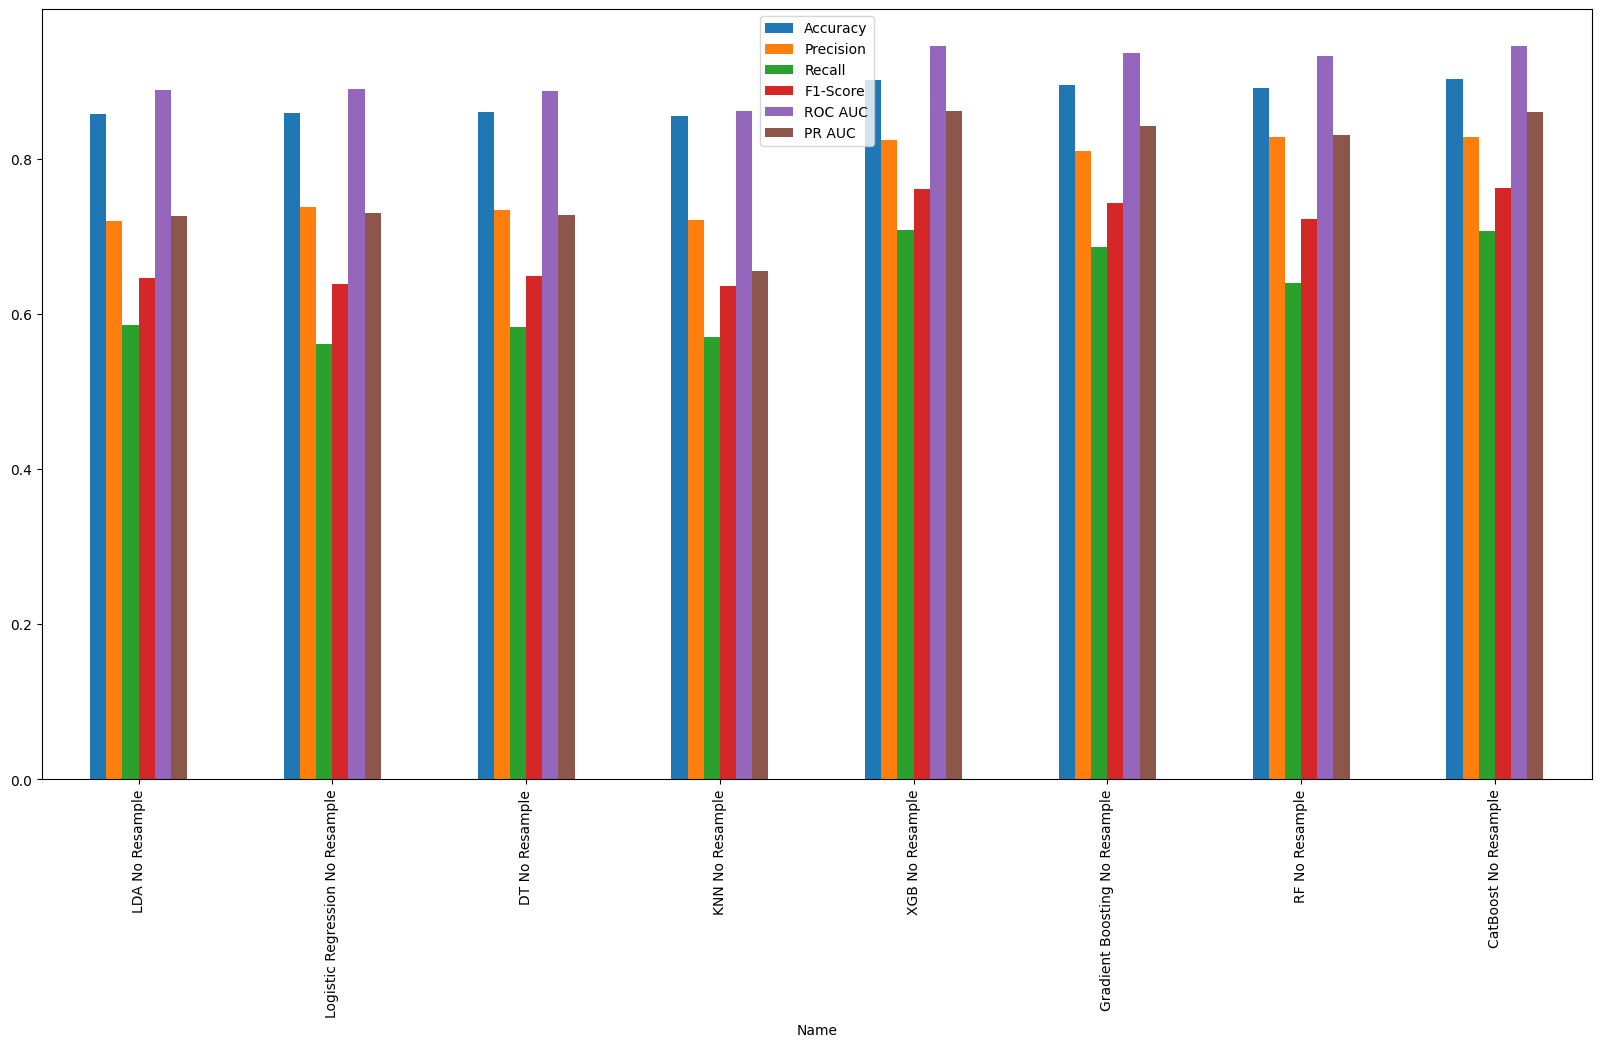

In [295]:
df = models_df[[x for x in models_df.columns if x != 'Confusion Matrix']]
df.plot.bar(figsize=(20,10))

In [296]:
for col in models_df.columns:
    if col != 'Confusion Matrix':
        print(models_df.sort_values(by=col, ascending=False)[col].head(1))

Name
CatBoost No Resample    0.90252
Name: Accuracy, dtype: object
Name
RF No Resample    0.828268
Name: Precision, dtype: object
Name
XGB No Resample    0.707692
Name: Recall, dtype: object
Name
CatBoost No Resample    0.762708
Name: F1-Score, dtype: object
Name
XGB No Resample    0.945631
Name: ROC AUC, dtype: object
Name
XGB No Resample    0.861717
Name: PR AUC, dtype: object


## SMOTE

In [297]:
models_df_smote

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA SMOTE  0.815552    0.5591  0.793205  0.655889   
0  Logistic Regression Smote  0.811546  0.551478   0.80141  0.653358   
0                   DT Smote  0.828309  0.593727  0.713462   0.64811   
0                  KNN SMOTE  0.800324  0.533589  0.786154  0.635704   
0                  XGB Smote  0.901185  0.811025  0.722436  0.764171   
0    Gradient Boosting SMOTE   0.88607  0.768262  0.695769  0.730221   
0                   RF SMOTE  0.883371  0.744346  0.721538  0.732765   
0             CatBoost SMOTE  0.894849  0.803765  0.695256  0.745583   

    ROC AUC               Confusion Matrix    PR AUC  
0   0.88866  [[22518, 4879], [1613, 6187]]  0.725605  
0  0.889268  [[22313, 5084], [1549, 6251]]  0.726433  
0  0.821544  [[23589, 3808], [2235, 5565]]  0.567173  
0  0.859808  [[22037, 5360], [1668, 6132]]   0.60389  
0  0.943458  [[26084, 1313], [2165, 5635]]  0.858693  
0  0.926696  [[25760, 1637], [2373, 5427]]  0.819595  
0  0.927489  [[25464, 1933], [2172, 5628]]  0.815336  
0  0.936532  [[26073, 1324], [2377, 5423]]  0.840984

In [298]:
models_df_smote.index = models_df_smote.Name
models_df_smote = models_df_smote.drop('Name',axis=1)

<Axes: xlabel='Name'>

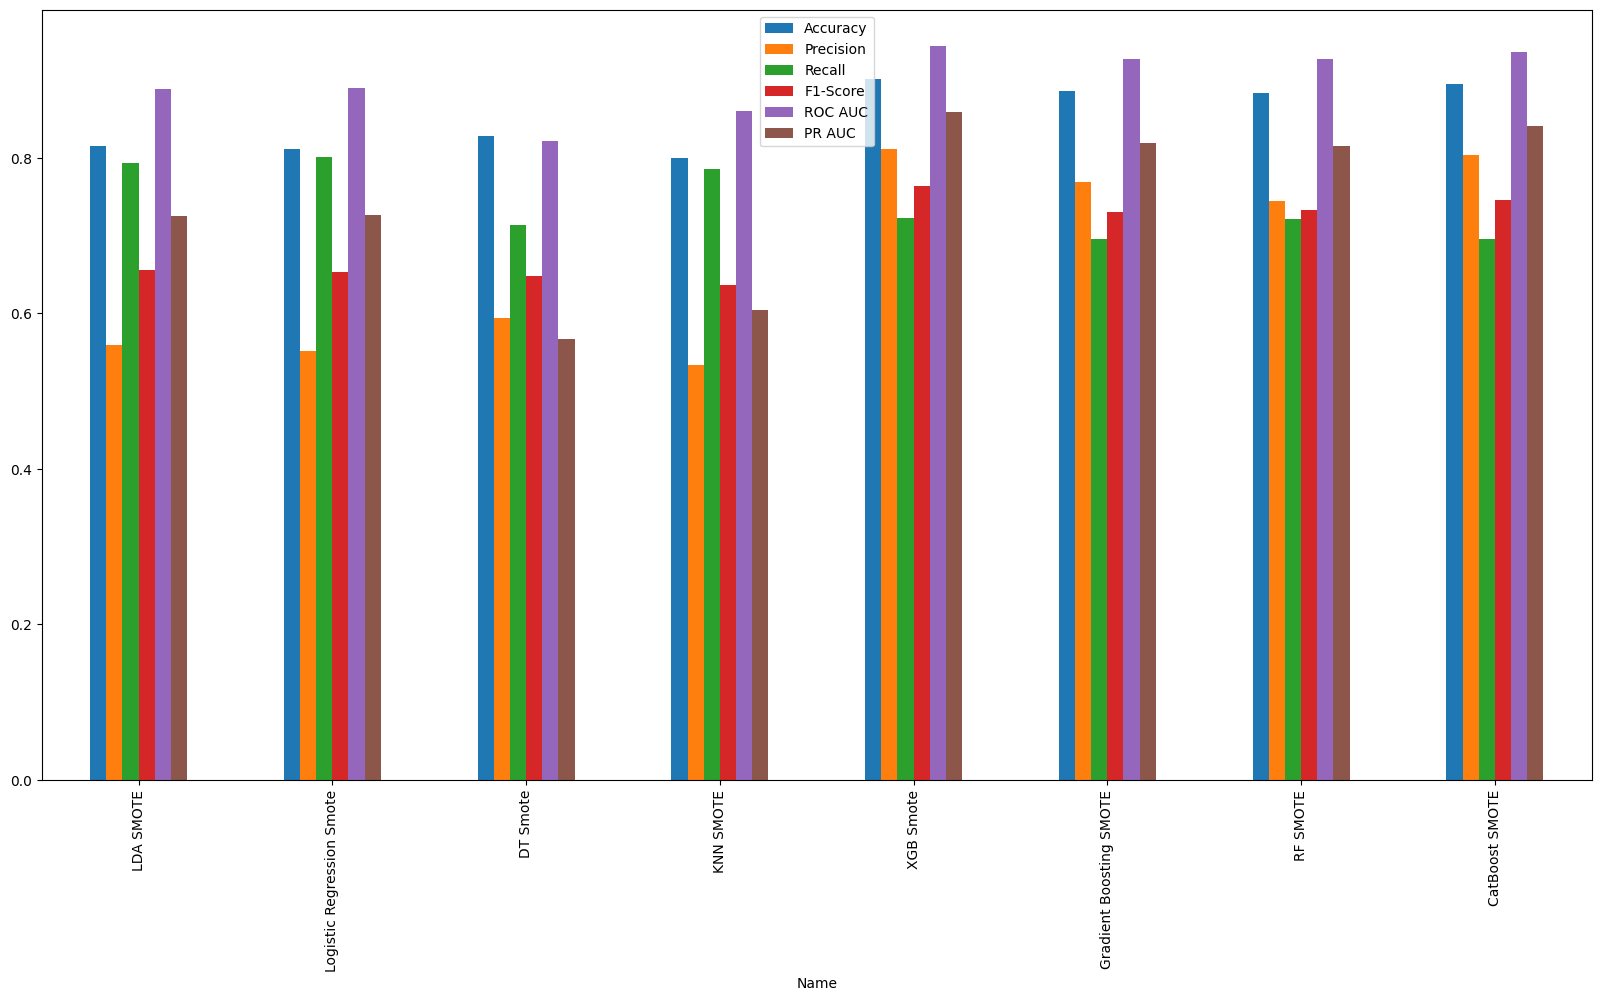

In [299]:
df_smote = models_df_smote[[x for x in models_df_smote.columns if x != 'Confusion Matrix']]
df_smote.plot.bar(figsize=(20,10))

In [300]:
for col in models_df_smote.columns:
    if col != 'Confusion Matrix':
        print(models_df_smote.sort_values(by=col, ascending=False)[col].head(1))

Name
XGB Smote    0.901185
Name: Accuracy, dtype: object
Name
XGB Smote    0.811025
Name: Precision, dtype: object
Name
Logistic Regression Smote    0.80141
Name: Recall, dtype: object
Name
XGB Smote    0.764171
Name: F1-Score, dtype: object
Name
XGB Smote    0.943458
Name: ROC AUC, dtype: object
Name
XGB Smote    0.858693
Name: PR AUC, dtype: object


## Undersample

In [301]:
models_df_under

Name  Accuracy Precision    Recall  F1-Score  \
0                  LDA undersample  0.815013  0.558152  0.793077  0.655193   
0  Logistic Regression Undersample  0.810893  0.550352  0.801538   0.65261   
0                   DT Undersample  0.802029  0.534882  0.817821  0.646761   
0                  KNN Undersample  0.796091   0.52621  0.801795  0.635408   
0                  XGB Undersample  0.861011  0.636449  0.869487  0.734937   
0    Gradient Boosting Undersample  0.853738  0.623395  0.858846   0.72242   
0                   RF Undersample  0.841521  0.601332  0.845256  0.702729   
0             CatBoost Undersample  0.856437  0.628521  0.861154  0.726673   

    ROC AUC               Confusion Matrix    PR AUC  
0  0.889145  [[22500, 4897], [1614, 6186]]  0.727491  
0  0.889737  [[22289, 5108], [1548, 6252]]  0.728241  
0  0.883984  [[21850, 5547], [1421, 6379]]  0.693253  
0  0.866117  [[21766, 5631], [1546, 6254]]  0.613828  
0  0.939268  [[23523, 3874], [1018, 6782]]  0.837919  
0  0.932756  [[23350, 4047], [1101, 6699]]  0.824284  
0  0.923079  [[23026, 4371], [1207, 6593]]  0.796929  
0  0.934184  [[23427, 3970], [1083, 6717]]  0.826278

In [302]:
models_df_under.index = models_df_under.Name
models_df_under = models_df_under.drop('Name',axis=1)

<Axes: xlabel='Name'>

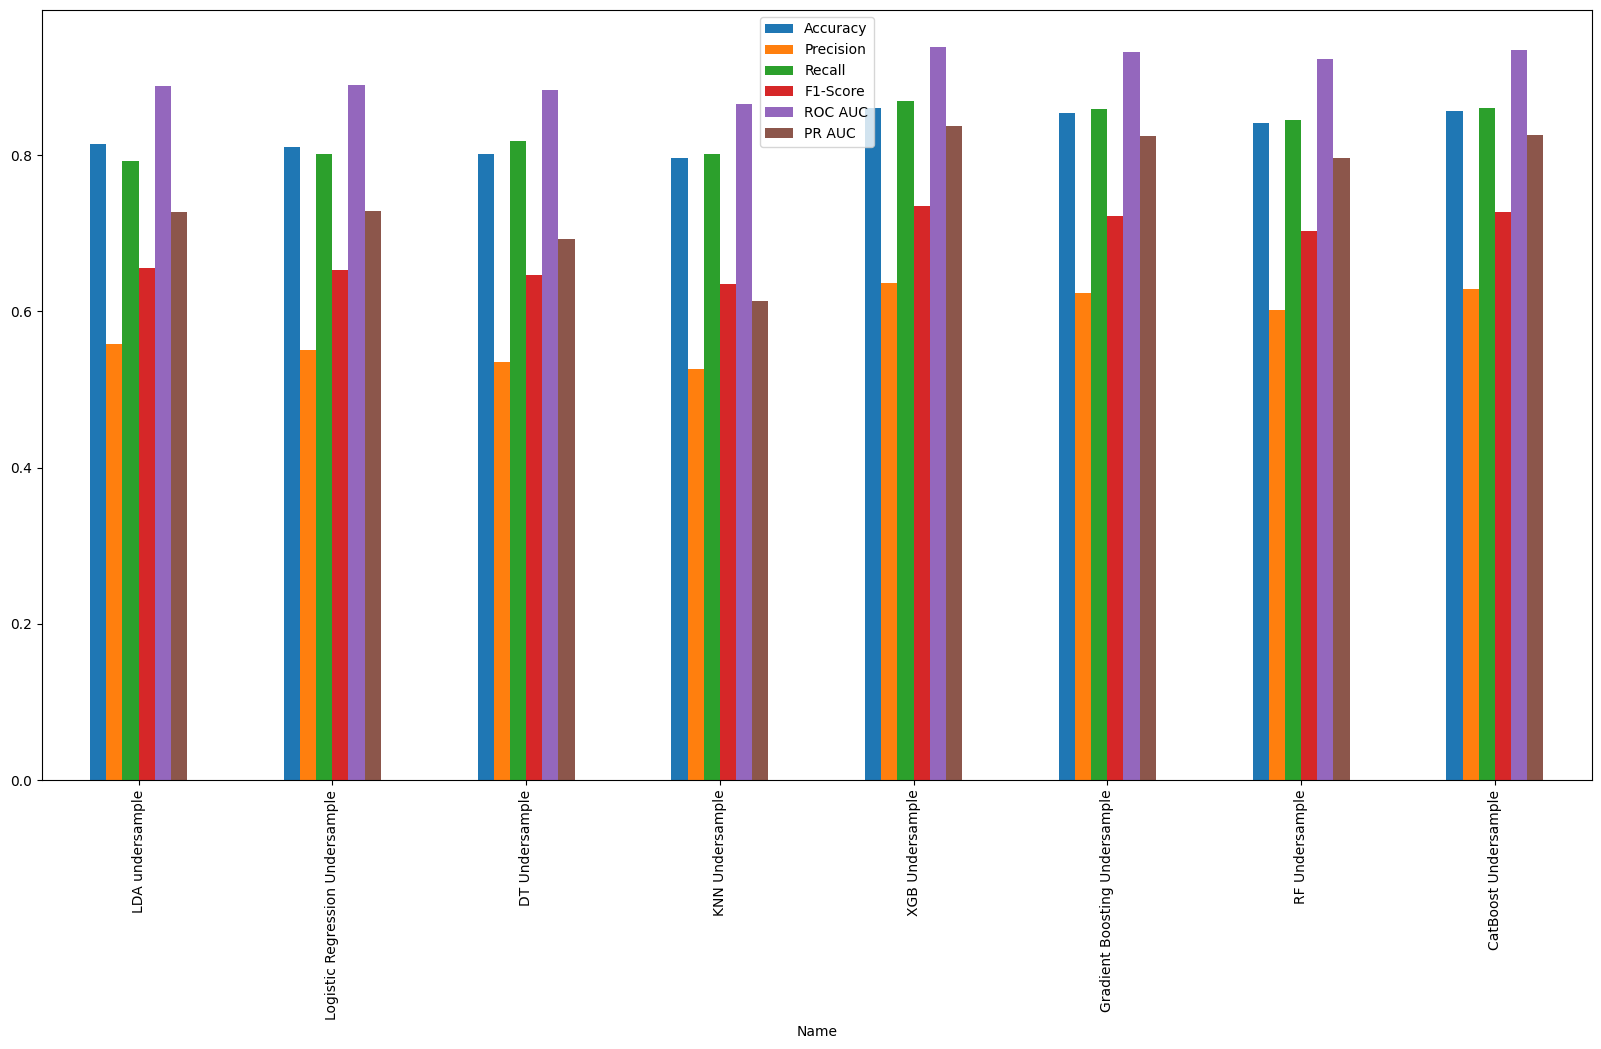

In [303]:
df_under = models_df_under[[x for x in models_df_under.columns if x != 'Confusion Matrix']]
df_under.plot.bar(figsize=(20,10))

In [304]:
for col in models_df_under.columns:
    if col != 'Confusion Matrix':
        print(models_df_under.sort_values(by=col, ascending=False)[col].head(1))

Name
XGB Undersample    0.861011
Name: Accuracy, dtype: object
Name
XGB Undersample    0.636449
Name: Precision, dtype: object
Name
XGB Undersample    0.869487
Name: Recall, dtype: object
Name
XGB Undersample    0.734937
Name: F1-Score, dtype: object
Name
XGB Undersample    0.939268
Name: ROC AUC, dtype: object
Name
XGB Undersample    0.837919
Name: PR AUC, dtype: object


# Deep Learning

In [ ]:
model = Sequential([
    Input(shape=[X_train.shape[1]]),
    Normalization(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(96, activation='relu'),
    Dense(96, activation='relu'),
    Dense(96, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'), 
    Dense(1, activation='sigmoid'),
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
history = model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_test, y_test),
    batch_size=256,
    epochs=10
)

Epoch 1/10
643/643 [==============================] - 6s 7ms/step - loss: 0.5370 - binary_accuracy: 0.7529 - val_loss: 0.5879 - val_binary_accuracy: 0.7217
Epoch 2/10
643/643 [==============================] - 4s 7ms/step - loss: 0.4486 - binary_accuracy: 0.7878 - val_loss: 0.3663 - val_binary_accuracy: 0.8374
Epoch 3/10
643/643 [==============================] - 5s 8ms/step - loss: 0.4414 - binary_accuracy: 0.7927 - val_loss: 0.6453 - val_binary_accuracy: 0.6875
Epoch 4/10
643/643 [==============================] - 6s 10ms/step - loss: 0.4356 - binary_accuracy: 0.7960 - val_loss: 0.3652 - val_binary_accuracy: 0.8292
Epoch 5/10
643/643 [==============================] - 7s 11ms/step - loss: 0.4346 - binary_accuracy: 0.7971 - val_loss: 0.4185 - val_binary_accuracy: 0.8045
Epoch 6/10
643/643 [==============================] - 6s 9ms/step - loss: 0.4295 - binary_accuracy: 0.7990 - val_loss: 0.4456 - val_binary_accuracy: 0.7700
Epoch 7/10
643/643 [==============================] - 4s 6ms/s

Best Validation Loss: 0.2824
Best Validation Accuracy: 0.8823


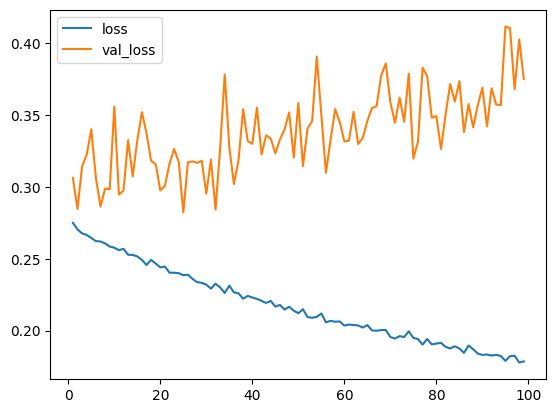

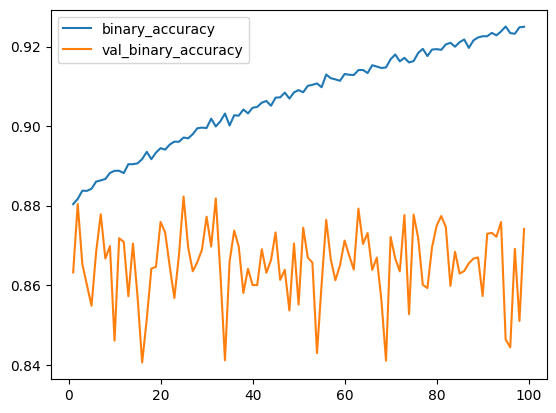

In [ ]:
history_df = pd.DataFrame(history.history)
# Start the plot at epoch 5
history_df.loc[1:, ['loss', 'val_loss']].plot()
history_df.loc[1:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

In [ ]:
y_pred_prob_test = model.predict(X_test)
y_pred_test = np.where(y_pred_prob_test.squeeze() < 0.5, 0, 1)
acc_test = metrics.accuracy_score(y_test, y_pred_test)
print(acc_test)

1100/1100 [==============================] - 2s 2ms/step
0.8741370003125266


In [ ]:
accuracy = metrics.accuracy_score(y_test, y_pred_test)
precision = metrics.precision_score(y_test, y_pred_test)
recall = metrics.recall_score(y_test, y_pred_test)
f1 = metrics.f1_score(y_test, y_pred_test)
roc_auc = metrics.roc_auc_score(y_test, y_pred_prob_test)
conf_mat = metrics.confusion_matrix(y_test, y_pred_test)
pr_auc = metrics.average_precision_score(y_test, y_pred_prob_test)
metrics_TF = pd.Series({
'Accuracy': accuracy,
'Precision': precision,
'Recall': recall,
'F1-Score': f1,
'ROC AUC': roc_auc,
'PR AUC': pr_auc,
'Confusion Matrix': conf_mat,
})
print(metrics_TF)
models_df = pd.concat([models_df, metrics_TF.to_frame().T])

Accuracy                                 0.874137
Precision                                0.686435
Recall                                   0.795385
F1-Score                                 0.736905
ROC AUC                                  0.921914
PR AUC                                   0.818549
Confusion Matrix    [[24563, 2834], [1596, 6204]]
dtype: object
